
# Try out Bayesian update to environmental estimate


In [1]:

# %%
#%%
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
import arviz as az
import arviz.labels as azl
#from hierarchical_normal_belk import hierarchical_normal
#import itertools
#!! conda install -c conda-forge flox
#import flox
#from flox.xarray import xarray_reduce # useful in doing multiple coord groupings


In [2]:
rng=np.random.Generator(np.random.PCG64(1234))


In [3]:

#Arviz to use bokeh in a notebook
az.style.use("arviz-doc")
# Confgure Bokeh as backend
az.rcParams["plot.backend"] = "bokeh"
az.output_notebook()
#get bokeh to work in vs code
import panel as pn
pn.extension(comms="vscode")
import hvplot.xarray

Loading BokehJS ...

In [35]:
size = 150 #size of grid
horz_offest = -150 #offset of grid from 0,0
mean_tempC_Km = 6.5/1000 #mean lapse rate
max_alt_Km = 13 #max altitude in km
#keep lat and long square for ease of matrixing
lat = np.arange(horz_offest, size)
long = np.arange(0, size - horz_offest)
alt = np.arange(0, max_alt_Km)*1000 #in meters

if (horz_offest > size):
    print ("horz_offest cannot be greater than size")
    exit(-1)

if (size < 1):
    print ("size cannot be less than 1")
    exit(-1)

if (max_alt_Km < 0):
    print ("max_alt_Km cannot be negative")
    exit(-1)


In [36]:
# AR is auto-regressive, MA is moving average; will only use AR 
def sample_AR_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"
    burn_samples = 100
    n_samples=n_samples+burn_samples

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))
    
    return np.array(signal[burn_samples:])
    
def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]



# Baseline thermal along latitude




0.5092128464315284


<Axes: >

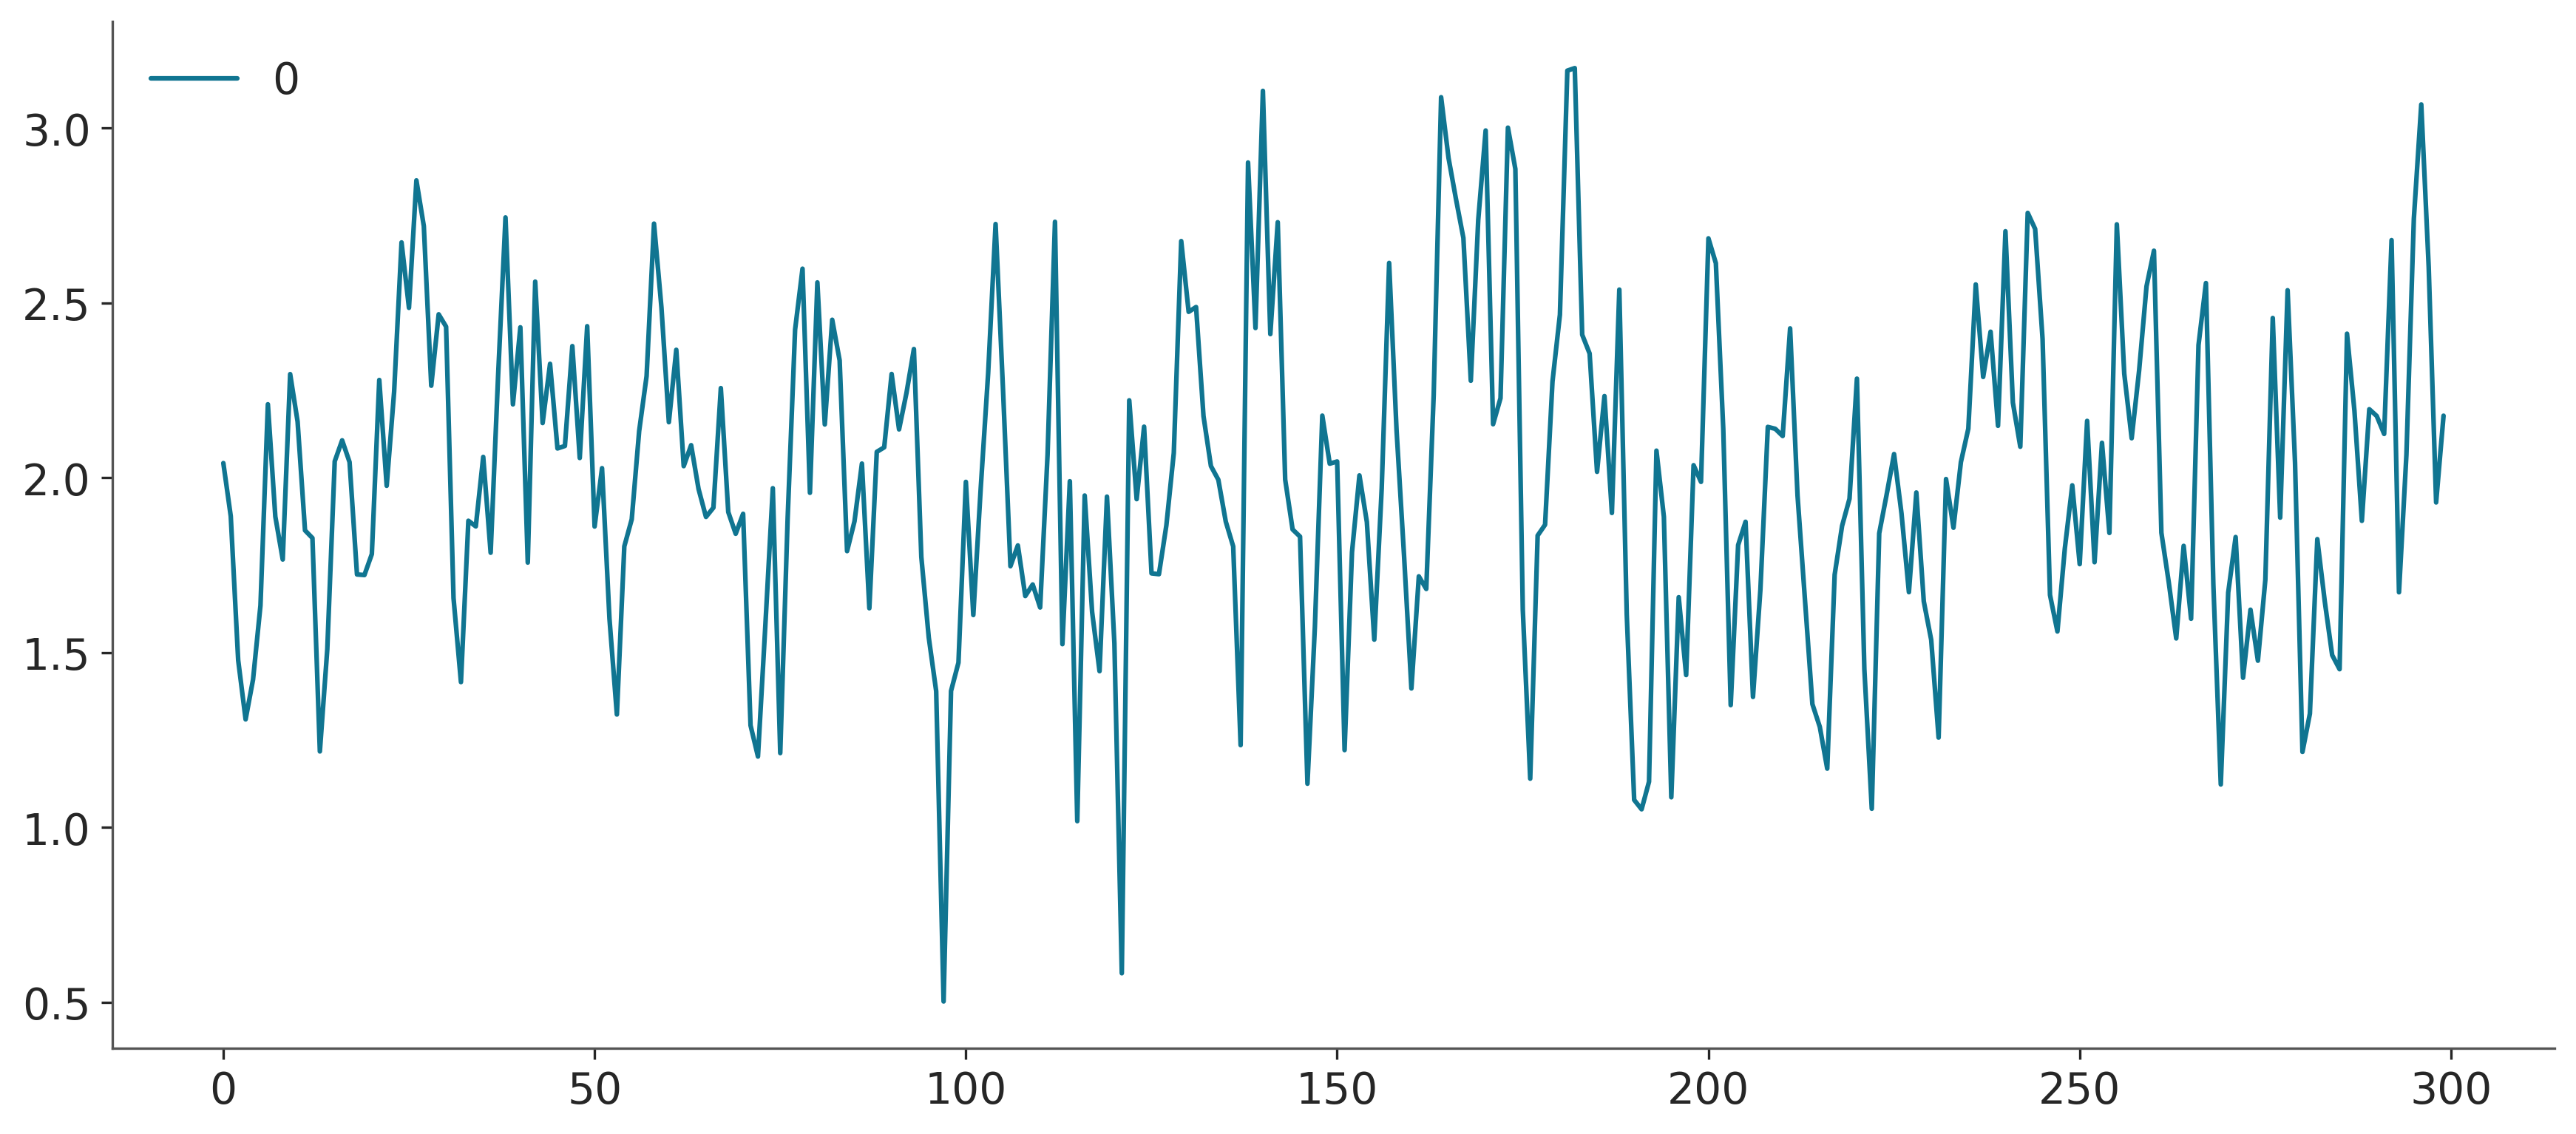

In [37]:
base_sigma = .5
samp_lat_base = sample_AR_signal(size-horz_offest, 0.5, mu=2, sigma=base_sigma)
samp_lat= pd.DataFrame(samp_lat_base)
print(compute_corr_lag_1(samp_lat_base))
samp_lat.plot()


# Extend along longitude


In [38]:
#use latitudes as mean for AR signal along longitudes
samp = sample_AR_signal(size-horz_offest, 0.75, mu=samp_lat, sigma=base_sigma)
samp = pd.DataFrame(samp[:, :, 0])
print(compute_corr_lag_1(samp.iloc[:,0]),compute_corr_lag_1(samp.iloc[0,:]))


0.6624960801235391 0.5092128464315284


C:\Users\willi\AppData\Local\Temp\ipykernel_30644\3278252664.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


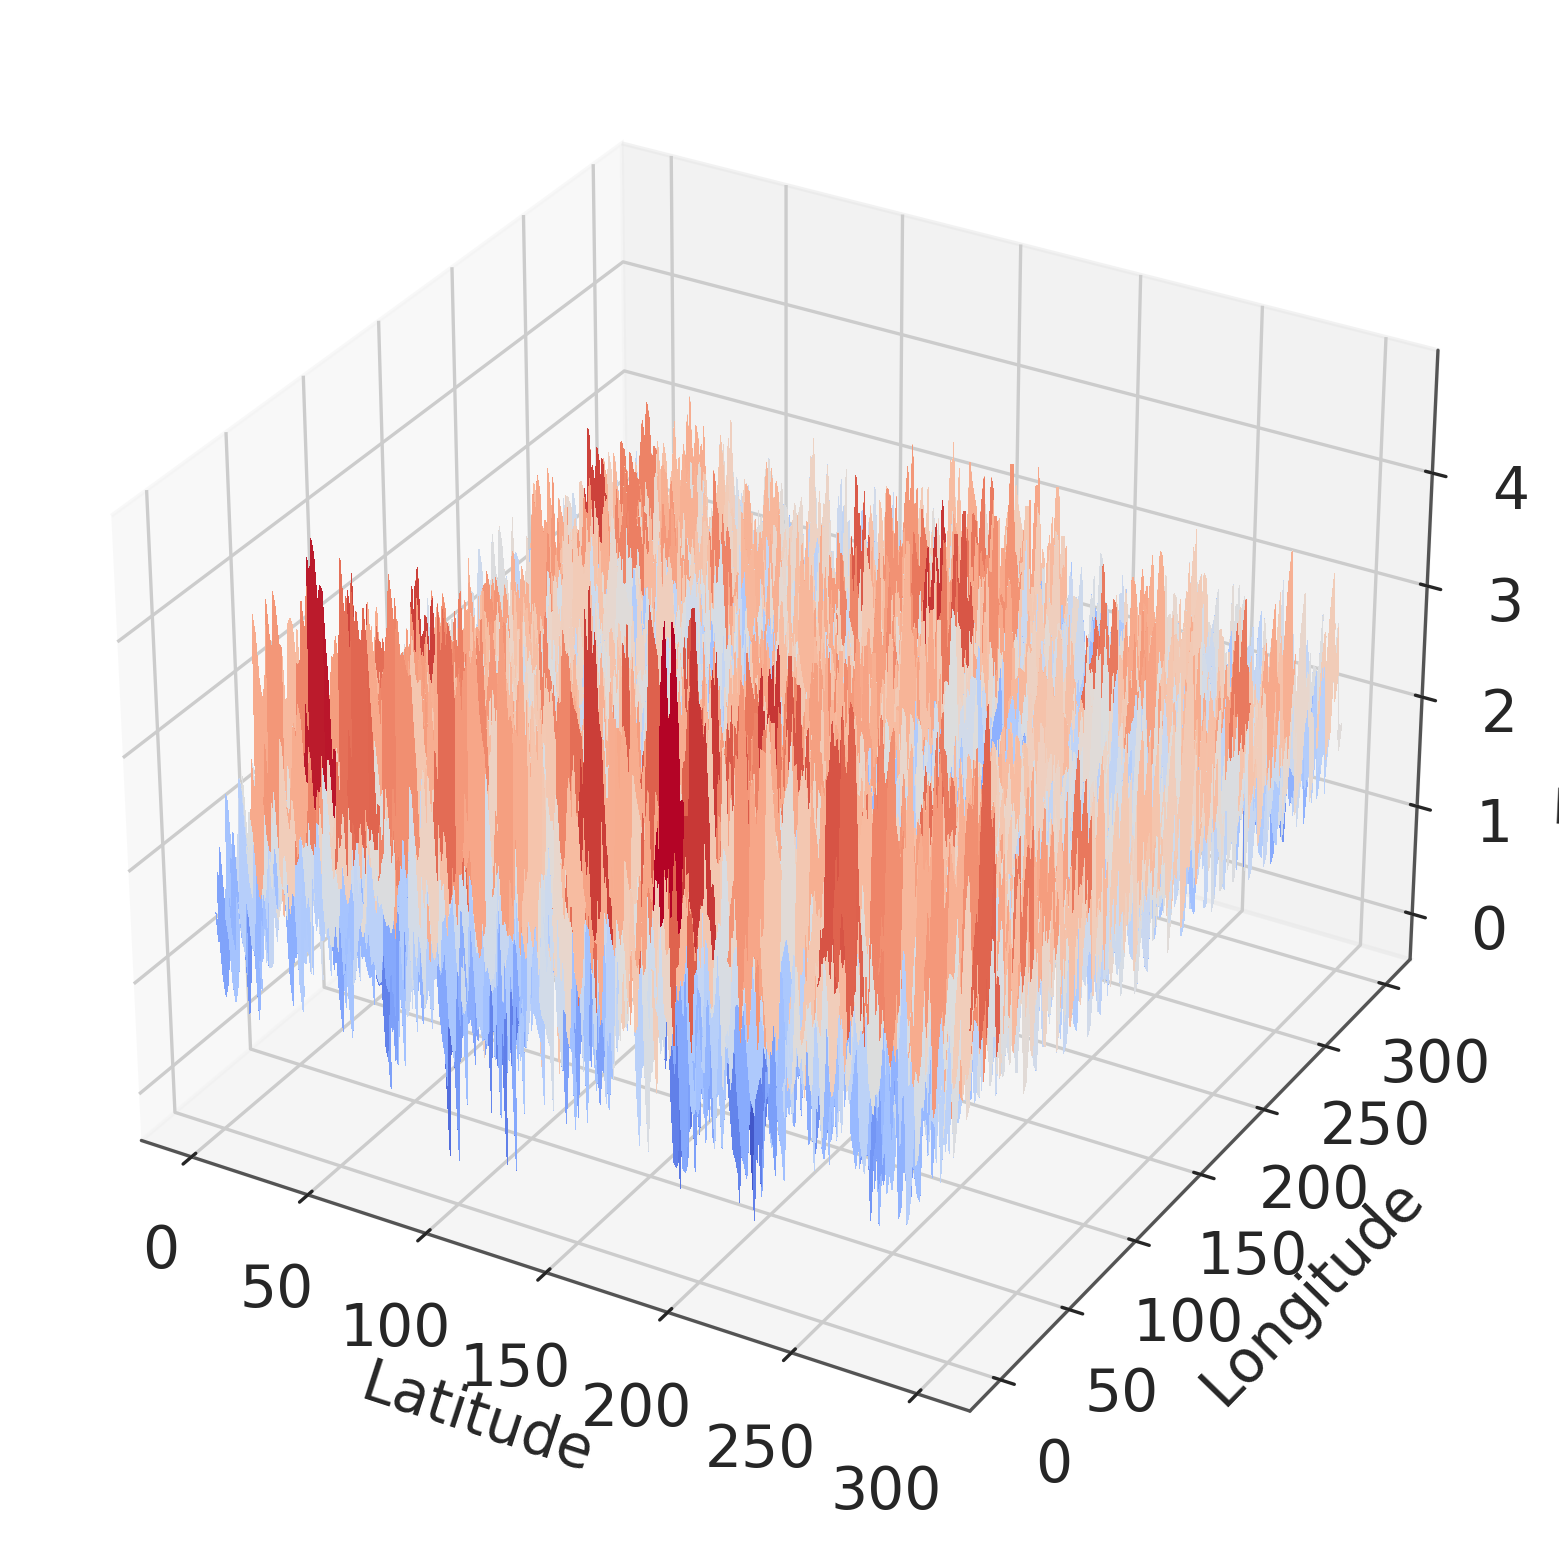

In [39]:

def plot_temperature_env(samp):
    x2, y2 = np.meshgrid(samp.index.values, samp.columns.values)
    plt.figure(figsize=(6,5))
    axes = plt.axes(projection='3d')
    axes.plot_surface(x2, y2,samp.values,cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
    axes.set_ylabel('Longitude')
    axes.set_xlabel('Latitude')
    axes.set_zlabel('Temperature')
    # keeps padding between figure elements
    plt.tight_layout()
    plt.show()

plot_temperature_env(samp)


# Add trend on top of the AR variation -- to baseline thermal


In [40]:
# add MA
lat_inc_slope = -10/(size - horz_offest)  #deterministic slope of increase in temperature with latitude
lat_inc_max = lat_inc_slope *(size-horz_offest) 
long_inc_mu, long_inc_std = 20/(size - horz_offest), .1  #mean and std of increase in temperature with longitude

def add_inc_MA(size, horz_offest, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std):
    lat_inc = np.linspace(0,lat_inc_max, len(samp_lat))
    sample_lat_inc = samp_lat[0] + lat_inc
    sample_lat_inc = pd.DataFrame(sample_lat_inc)
#sample_lat_inc.plot()

    samp_inc = sample_AR_signal(size-horz_offest, corr=0.5, mu=sample_lat_inc)
    long_inc = stats.norm.rvs(loc=long_inc_mu, scale=long_inc_std, size=(size-horz_offest,size-horz_offest), random_state=None)
    long_inc = np.cumsum(long_inc, axis=0)
    samp_inc = pd.DataFrame(samp_inc[:, :, 0]+long_inc)
    return samp_inc

samp_inc = add_inc_MA(size, horz_offest, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std)
#bump temperature up to standard atmosphere
samp_inc=samp_inc+15-2


C:\Users\willi\AppData\Local\Temp\ipykernel_30644\3278252664.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


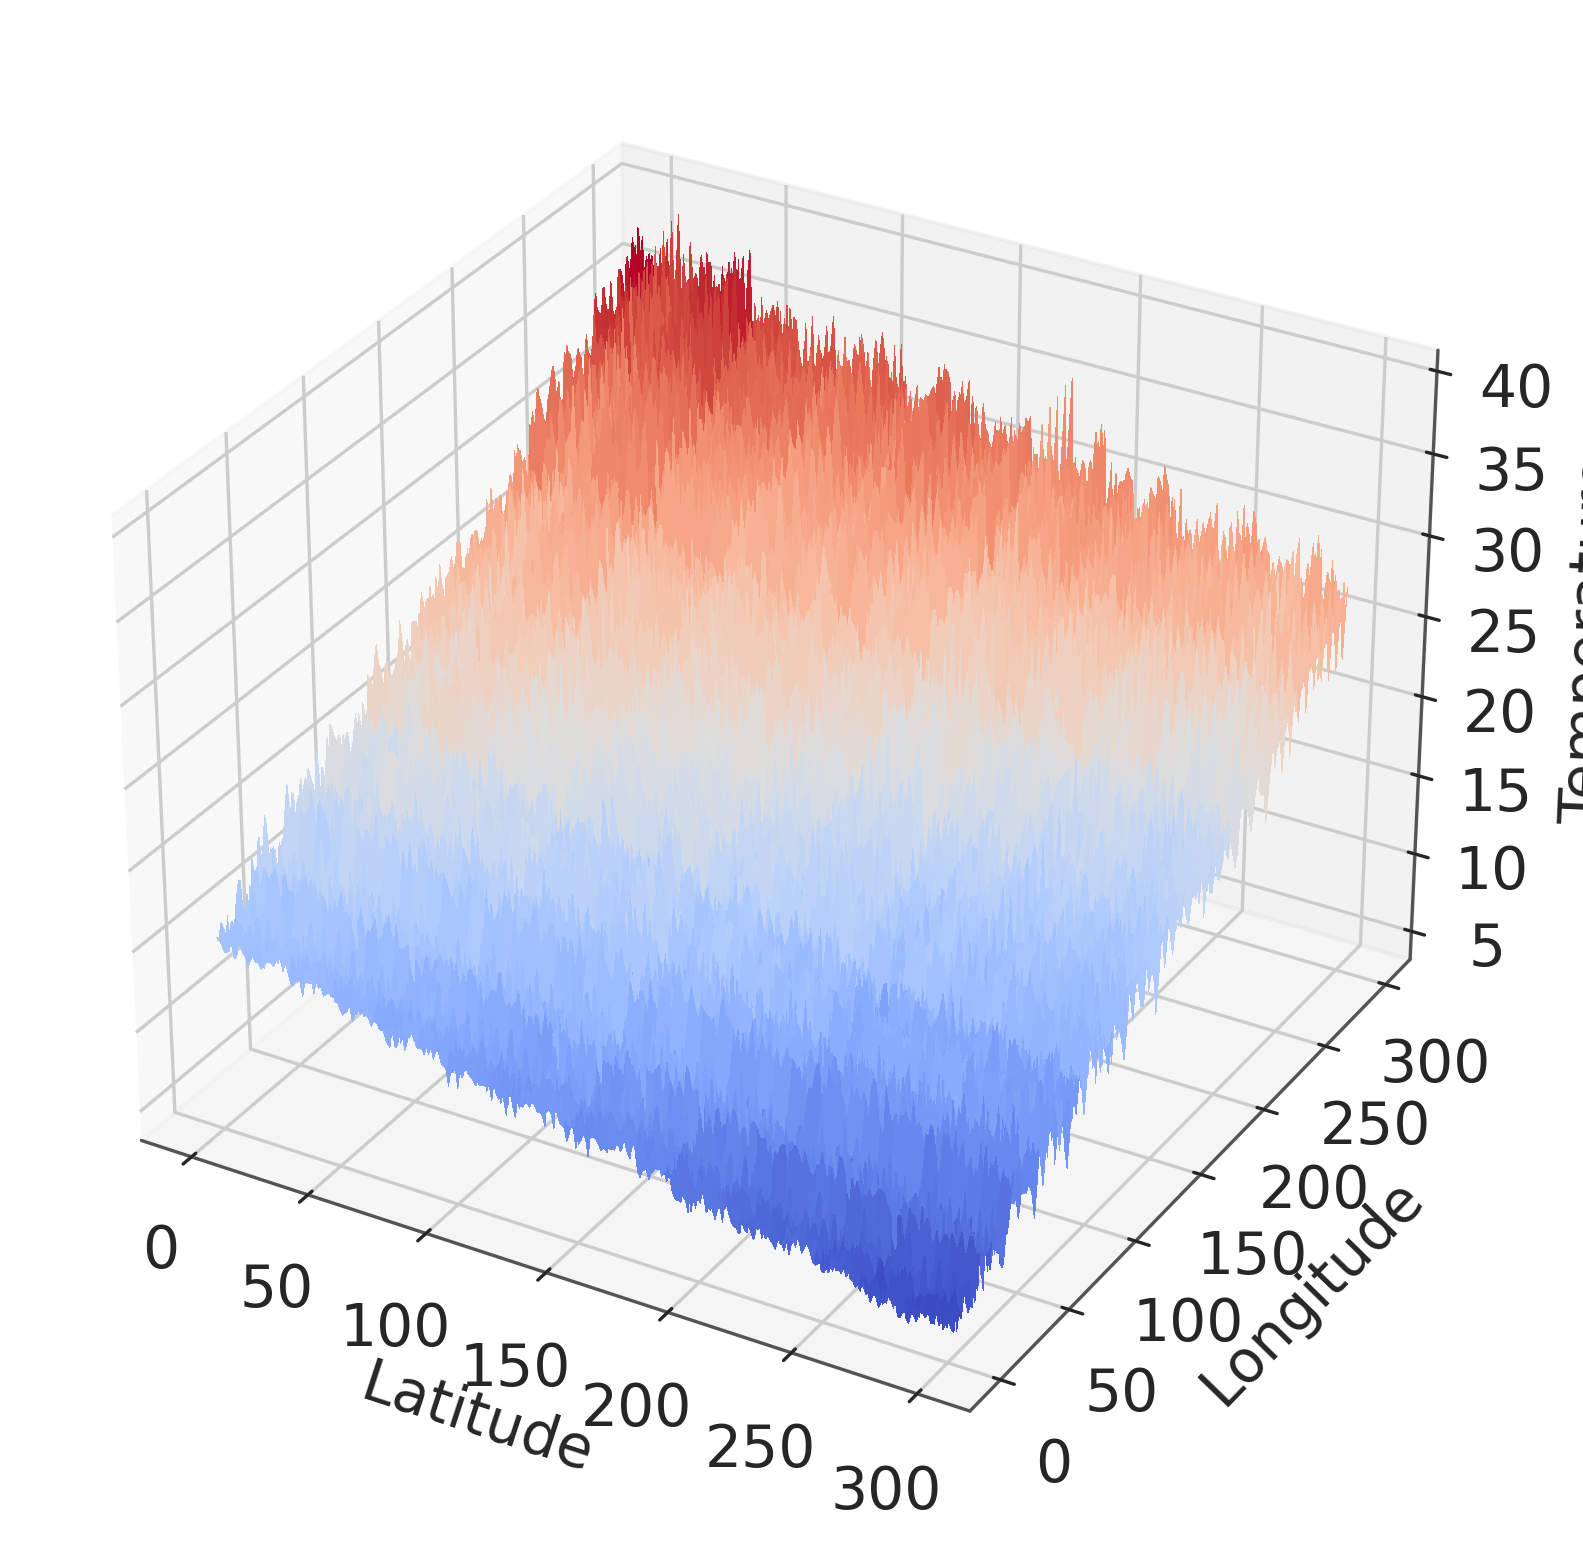

In [41]:

plot_temperature_env(samp_inc)



# Extend into atmosphere


In [42]:

#allow for inversion by having random lapse rate at diff altitudes
def add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km):
    tempC_Km = rng.normal(loc=mean_tempC_Km, scale=mean_tempC_Km/100, size=max_alt_Km)
    temperature = ( [np.array(samp_inc) 
                 for _ in np.arange(max_alt_Km)]
               -np.broadcast_to(
    tempC_Km * alt, (size-horz_offest,size-horz_offest,max_alt_Km)
    ).T)
    temperature = temperature.T
    return temperature

temp_3D = add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km)


# Check for NaN values
if np.any(np.isnan(temp_3D)):
    raise ValueError("Temperature values cannot be NaN")



c:\Users\willi\OneDrive\Documents\GitHub\Weather\.conda\lib\site-packages\xarray\plot\facetgrid.py:674: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()
C:\Users\willi\AppData\Local\Temp\ipykernel_30644\2377006587.py:6: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)


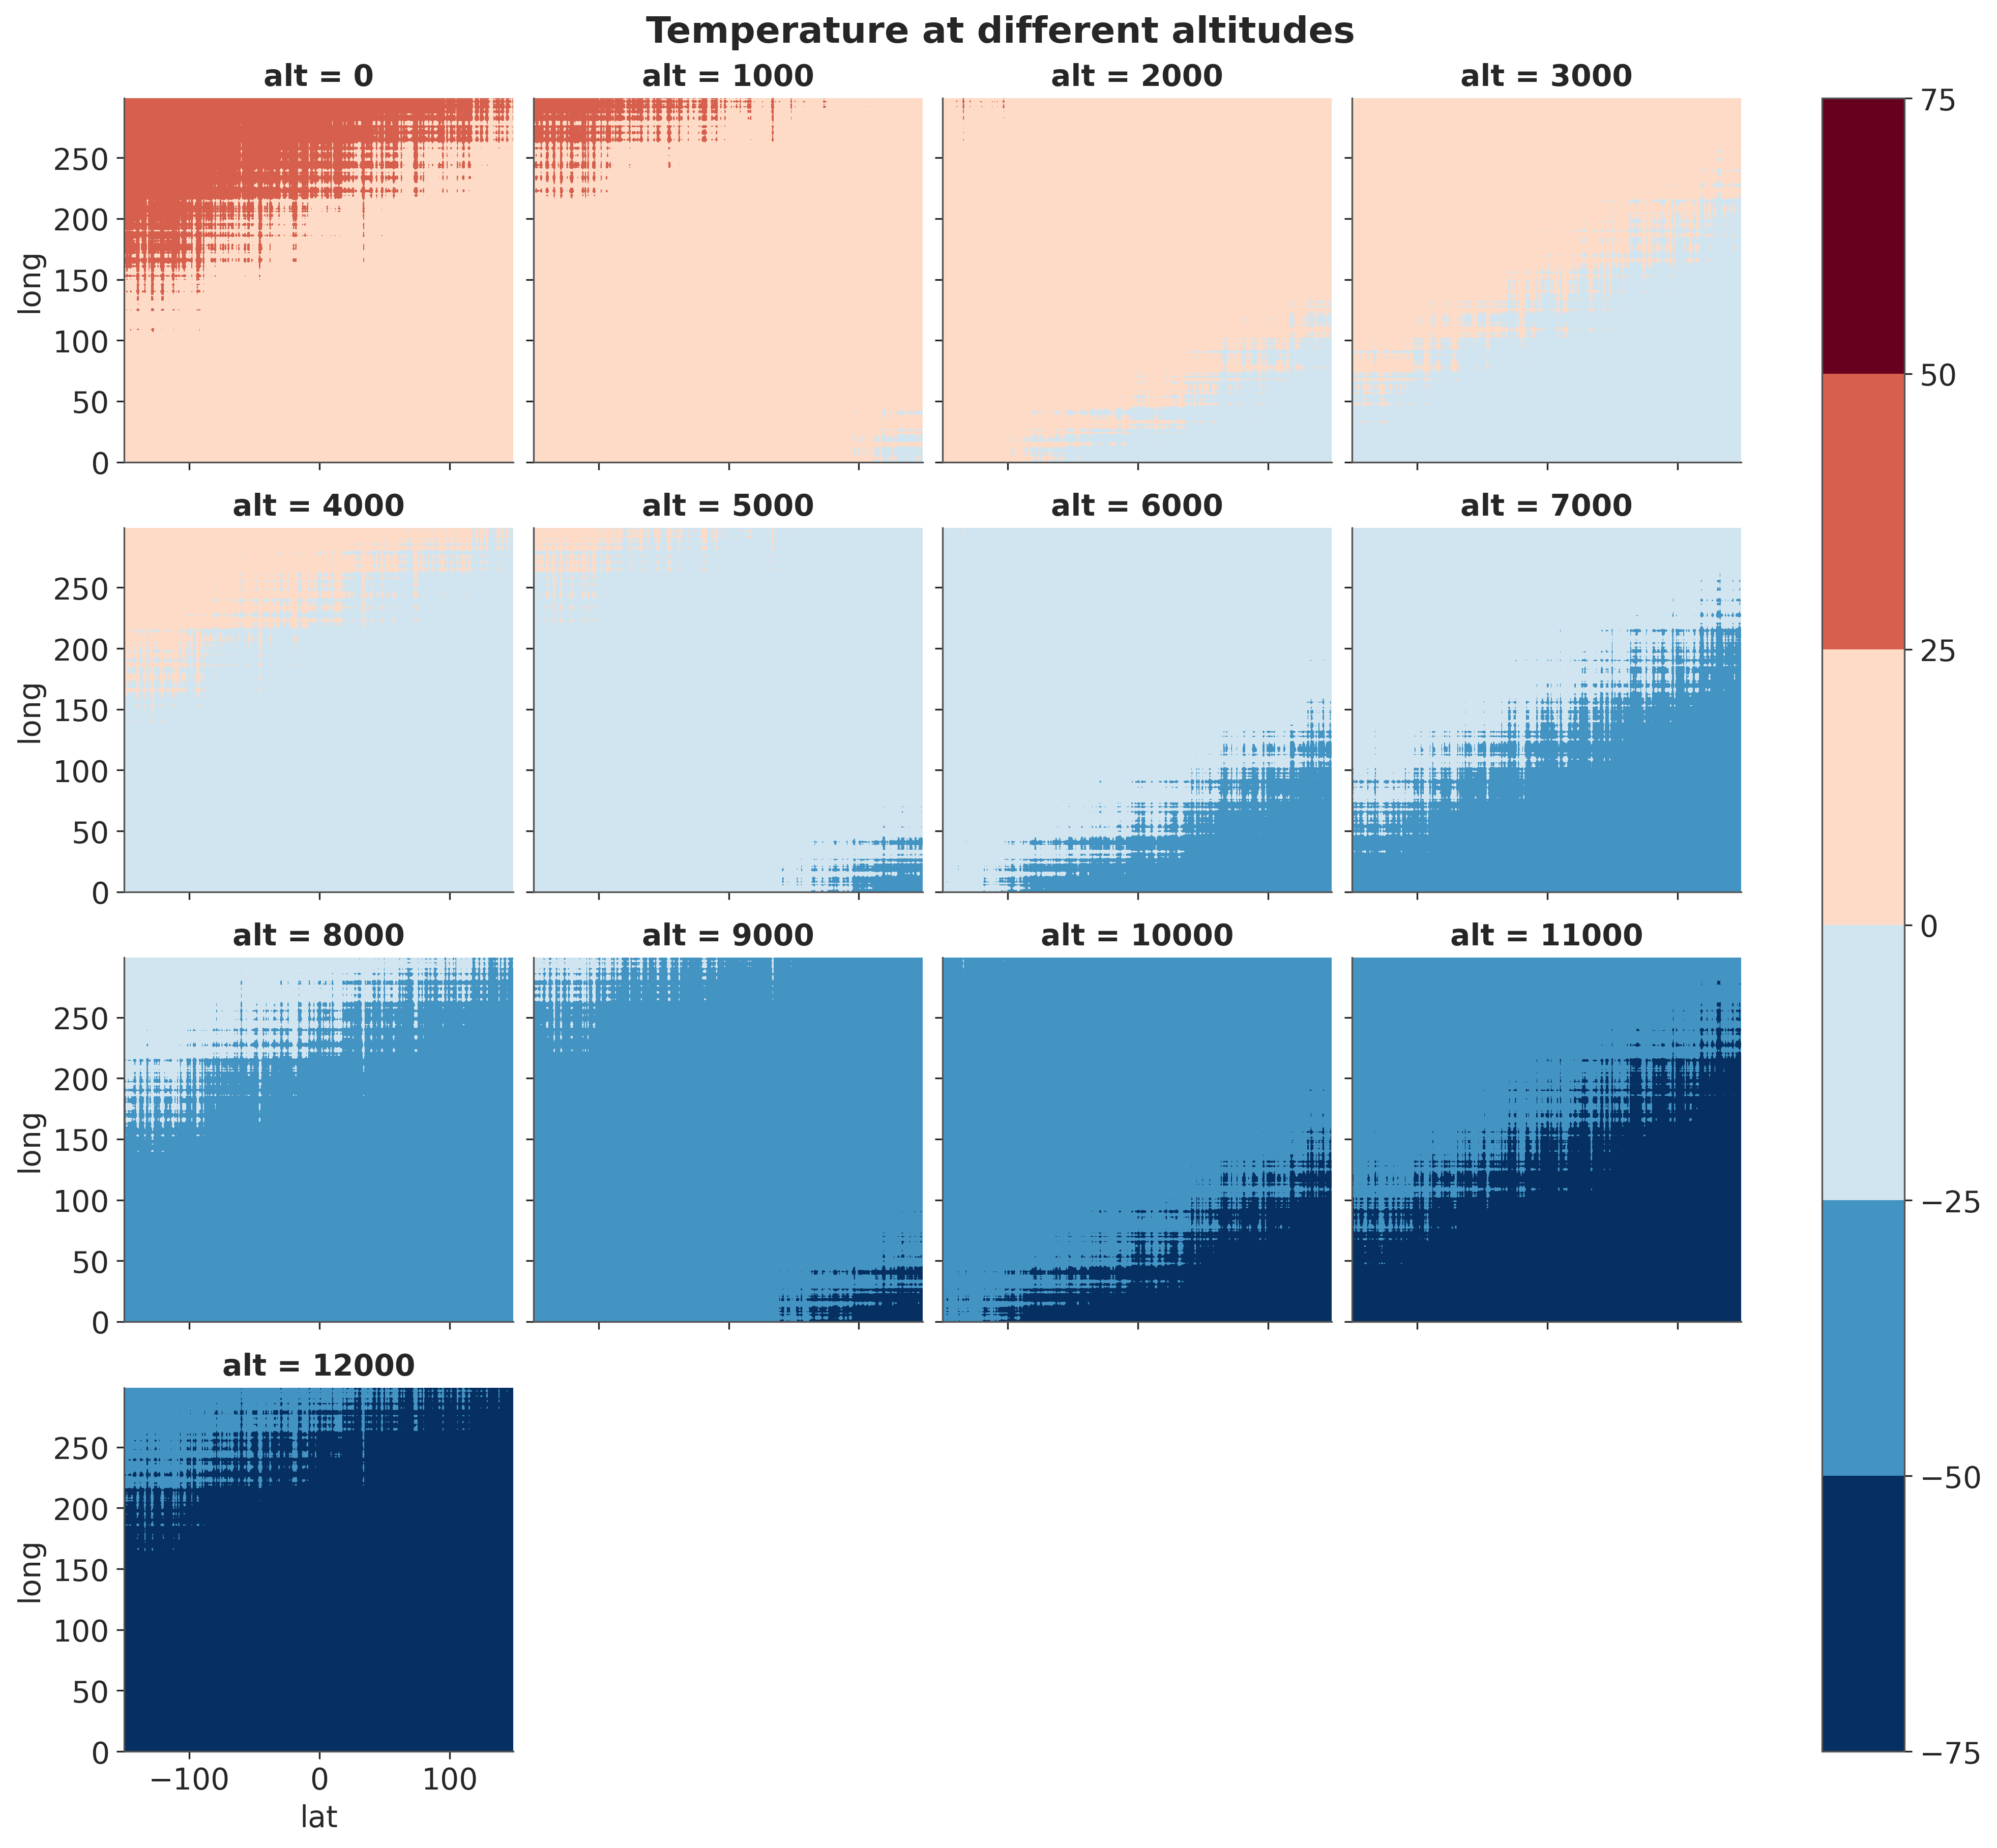

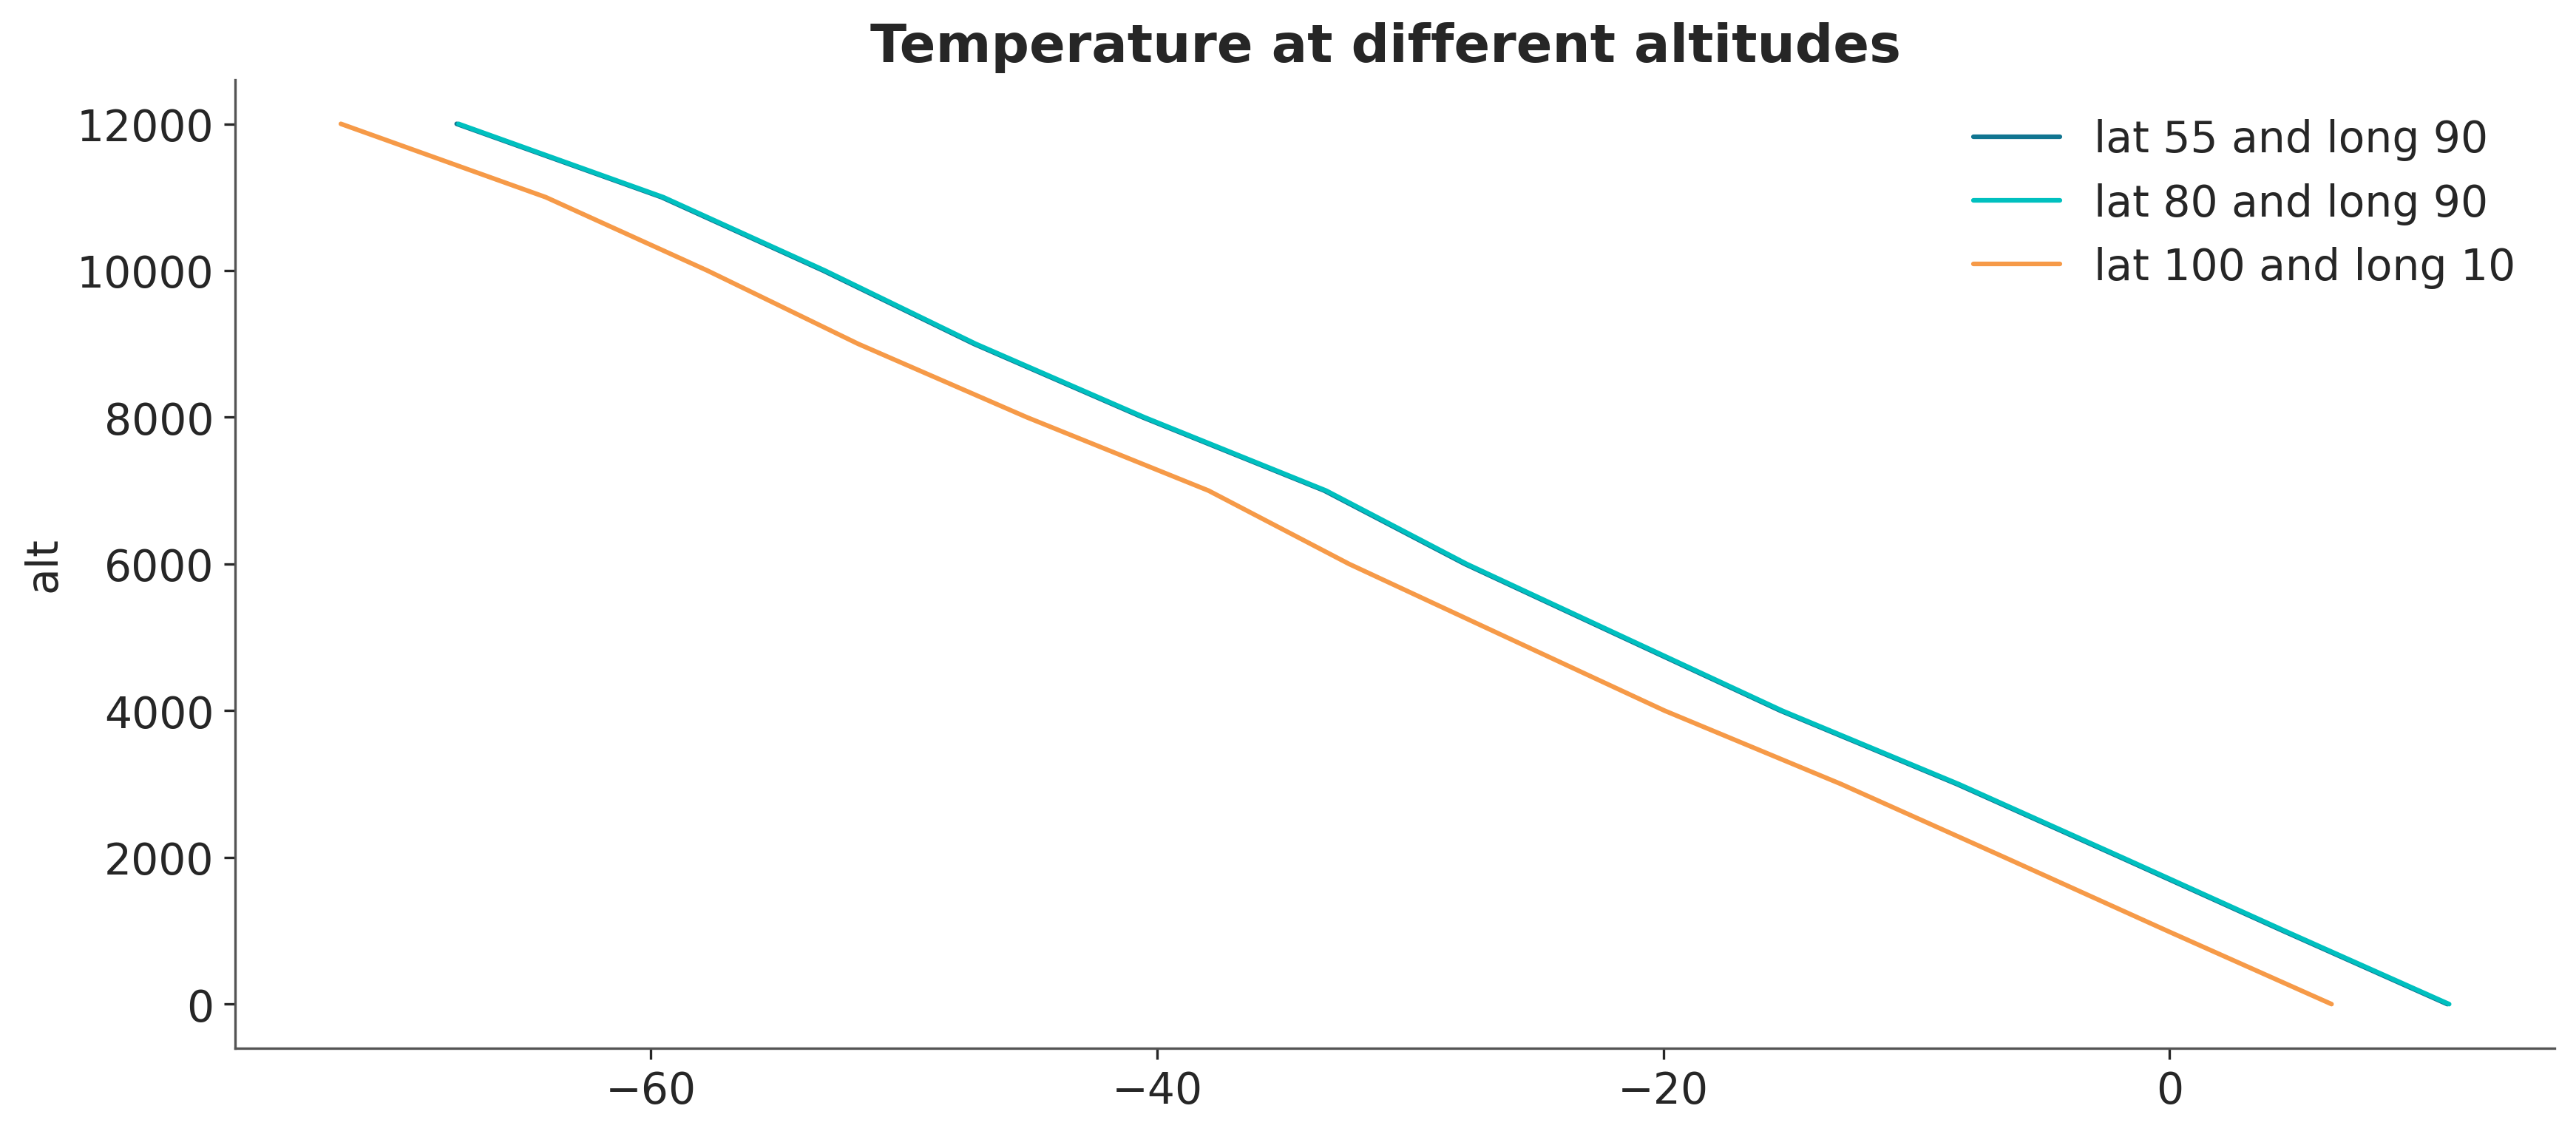

In [43]:

xr_temp_3D = xr.DataArray(temp_3D, dims=['lat', 'long', 'alt'], coords={'lat': lat, 'long': long, 'alt': alt})
fig = xr_temp_3D.plot.contourf(x='lat',y='long',col='alt', col_wrap=4,
                         robust=True)#, vmin=-90, vmax=32, levels=20)
plt.suptitle('Temperature at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)
plt.show()
 # plot temperature at different altitudes for lat 55 and long 90 and lat 80 and long 90 and lat 100 and long 100 

xr_temp_3D.sel(lat=55, long=90).plot(y='alt')
xr_temp_3D.sel(lat=80, long=90).plot(y='alt')
xr_temp_3D.sel(lat=100, long=10).plot(y='alt')
title = 'Temperature at different altitudes '
plt.title(title, fontsize = 'xx-large', weight = 'extra bold')
plt.legend(['lat 55 and long 90', 'lat 80 and long 90', 'lat 100 and long 10'])



xr_tempC_Km=  xr.DataArray(mean_tempC_Km, dims=['alt'], coords={'alt': alt})


In [44]:
xr_temp_3D.name = 'temp'
xr_temp_3D.attrs['name'] = 'temp'
xr_temp_3D

<xarray.DataArray 'temp' (lat: 300, long: 300, alt: 13)>
array([[[ 15.19639683,   8.69554003,   2.28469932, ..., -48.96956921,
         -55.35241835, -63.44787739],
        [ 14.95653232,   8.45567552,   2.04483482, ..., -49.20943372,
         -55.59228285, -63.68774189],
        [ 15.41646095,   8.91560415,   2.50476345, ..., -48.74950509,
         -55.13235422, -63.22781326],
        ...,
        [ 37.54428271,  31.04342591,  24.63258521, ..., -26.62168332,
         -33.00453246, -41.0999915 ],
        [ 35.67248056,  29.17162376,  22.76078305, ..., -28.49348548,
         -34.87633462, -42.97179366],
        [ 37.66150782,  31.16065101,  24.74981031, ..., -26.50445822,
         -32.88730736, -40.9827664 ]],

       [[ 15.0562215 ,   8.55536469,   2.14452399, ..., -49.10974454,
         -55.49259368, -63.58805272],
        [ 14.92181165,   8.42095485,   2.01011415, ..., -49.24415439,
         -55.62700352, -63.72246256],
        [ 15.39812713,   8.89727033,   2.48642963, ..., -48.76783891,
         -55.15068805, -63.24614709],
...
        [ 22.96845704,  16.46760024,  10.05675954, ..., -41.197509  ,
         -47.58035813, -55.67581717],
        [ 21.047448  ,  14.5465912 ,   8.13575049, ..., -43.11851804,
         -49.50136718, -57.59682622],
        [ 22.9576299 ,  16.45677309,  10.04593239, ..., -41.20833614,
         -47.59118528, -55.68664432]],

       [[  5.48992937,  -1.01092743,  -7.42176814, ..., -58.67603667,
         -65.05888581, -73.15434485],
        [  5.21078674,  -1.29007006,  -7.70091076, ..., -58.9551793 ,
         -65.33802843, -73.43348747],
        [  5.46715474,  -1.03370206,  -7.44454276, ..., -58.6988113 ,
         -65.08166043, -73.17711947],
        ...,
        [ 27.26718256,  20.76632576,  14.35548506, ..., -36.89878348,
         -43.28163262, -51.37709166],
        [ 25.58705863,  19.08620183,  12.67536112, ..., -38.57890741,
         -44.96175655, -53.05721559],
        [ 27.5149375 ,  21.01408069,  14.60323999, ..., -36.65102854,
         -43.03387768, -51.12933672]]])
Coordinates:
  * lat      (lat) int32 -150 -149 -148 -147 -146 -145 ... 145 146 147 148 149
  * long     (long) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * alt      (alt) int32 0 1000 2000 3000 4000 ... 8000 9000 10000 11000 12000
Attributes:
    name:     temp

'    ax.set_extent([-180, 180, -90, 90])\n    ax.set_aspect("auto")\n    ax.set_title(ax.get_title().replace("altitude = ",""))\n    ax.set_xlabel("Longitude")\n    ax.set_ylabel("Latitude")\n    ax.gridlines(draw_labels=True)\n    ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())\n    ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())\n    ax.tick_params(labelsize=8)'

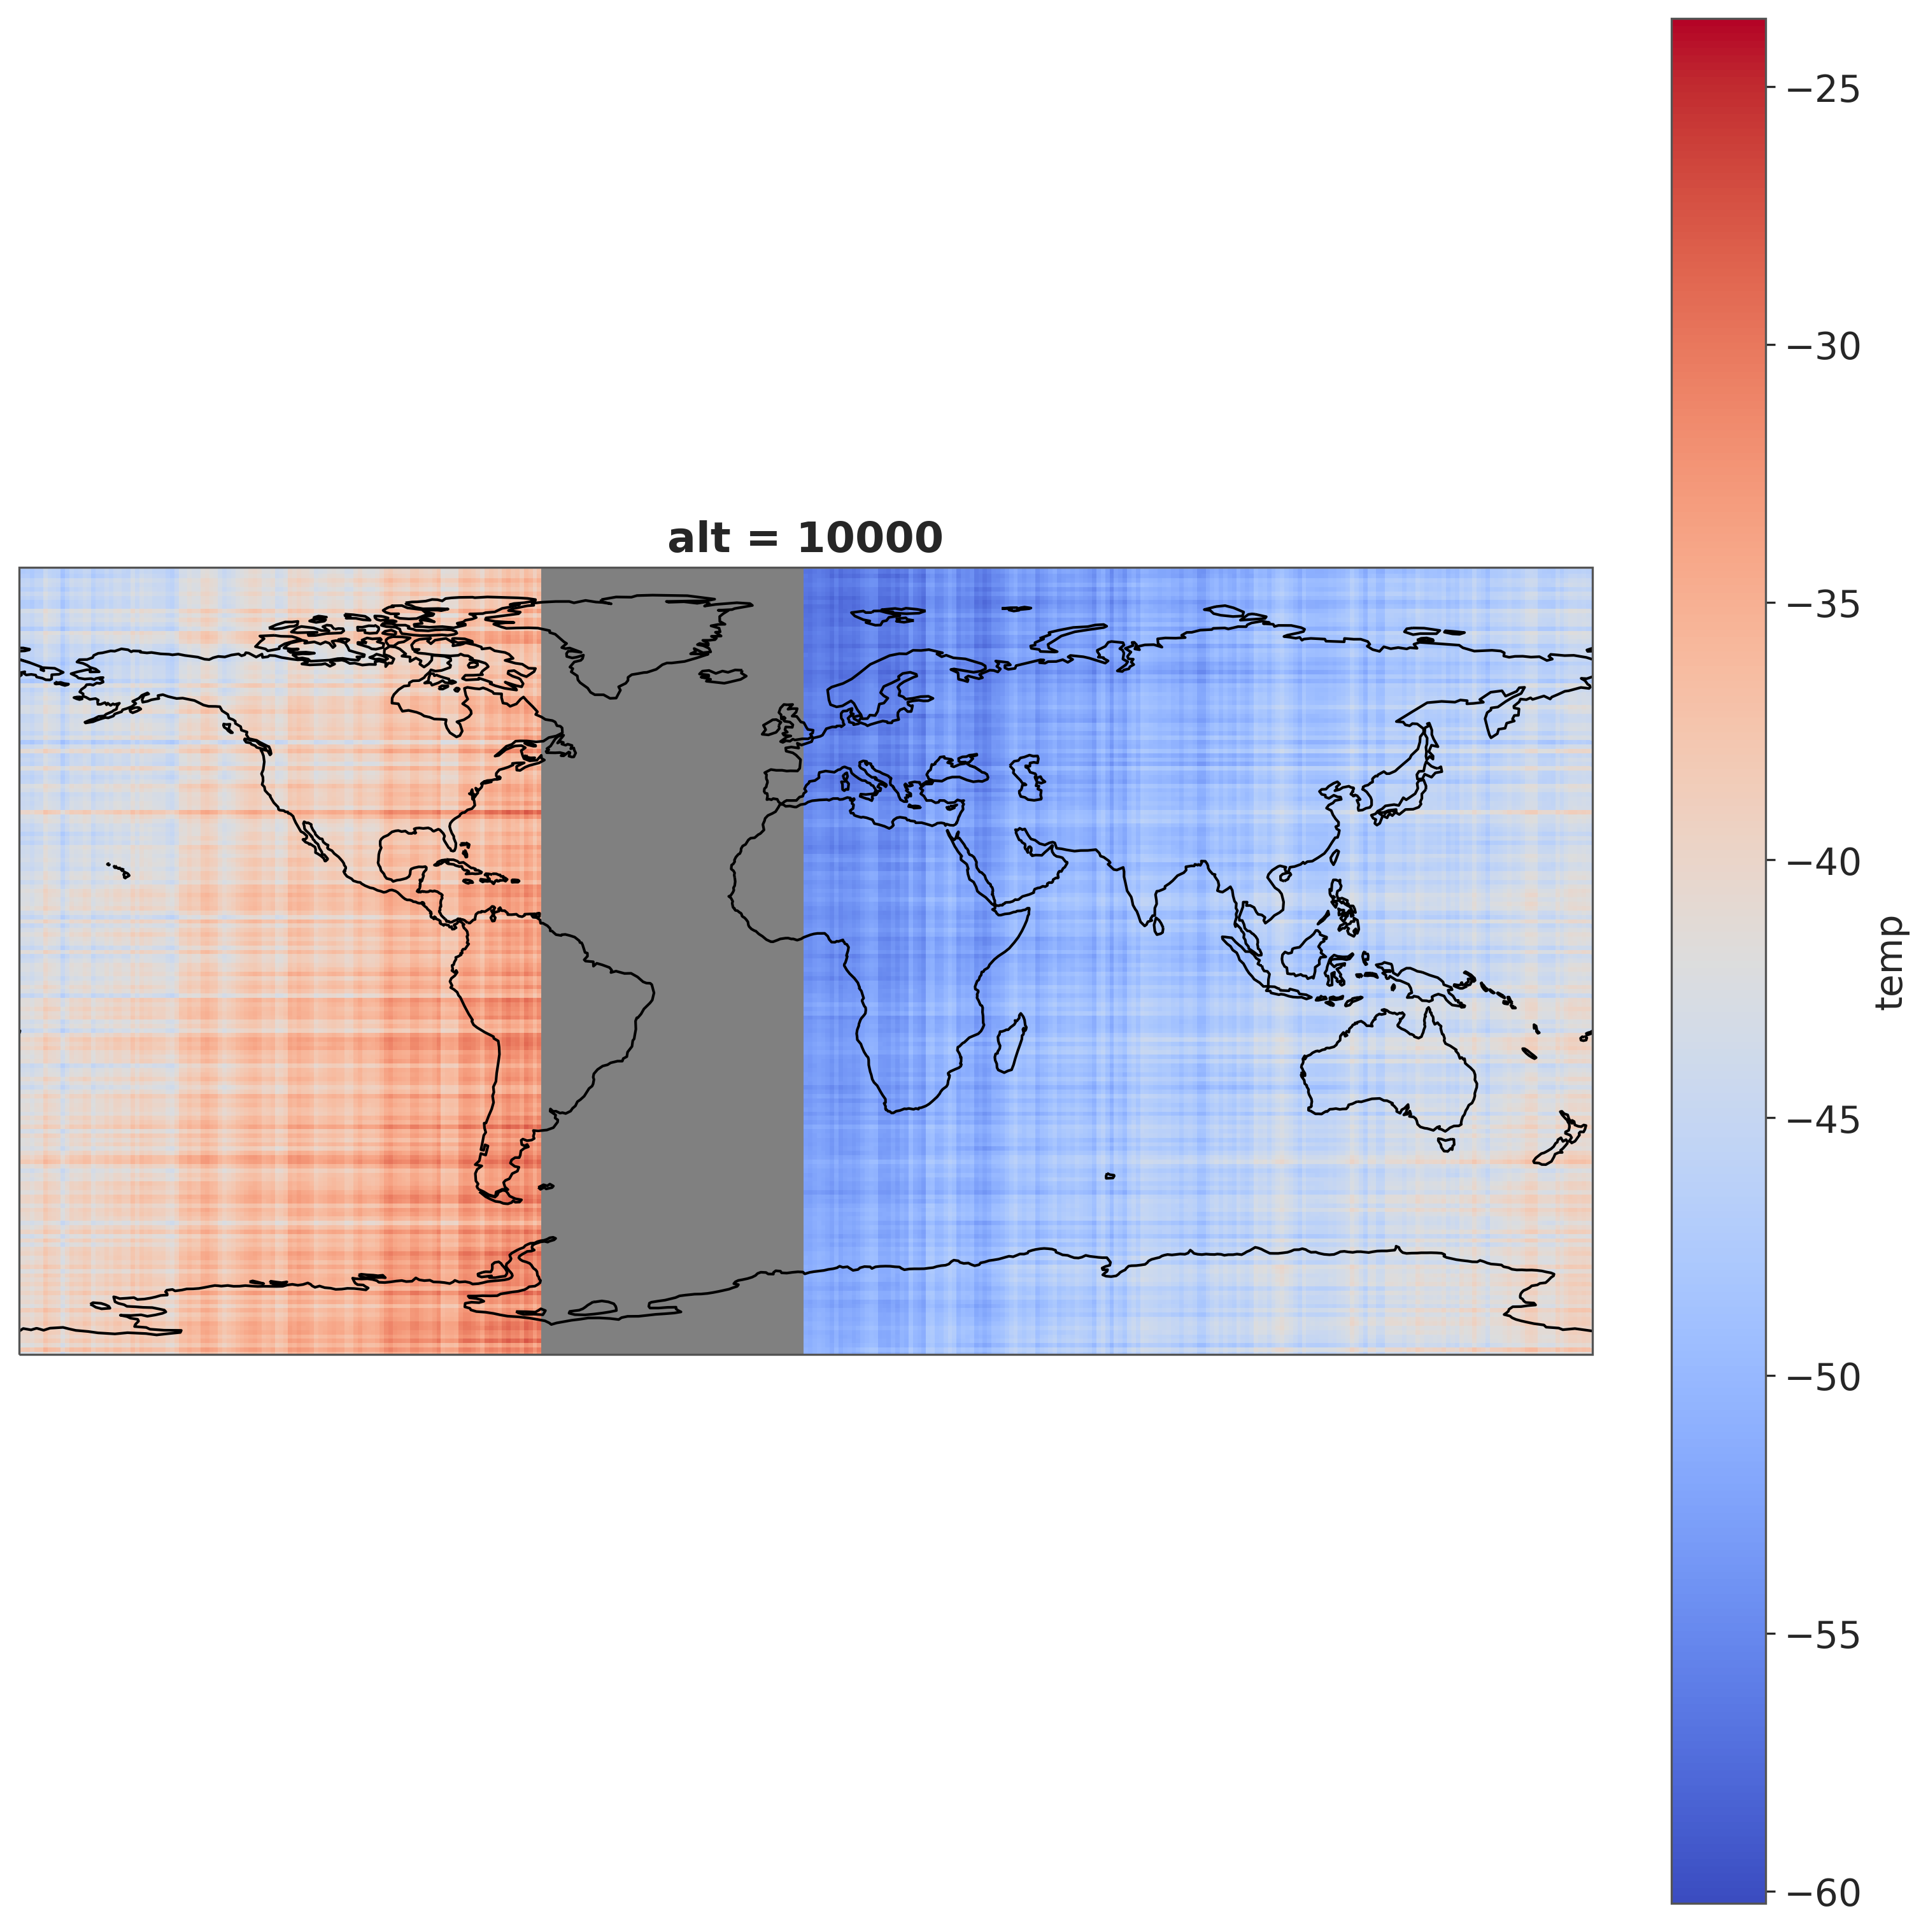

In [45]:
# copilot: project this onto globe using xarray
# https://xarray.pydata.org/en/stable/plotting.html
import cartopy.crs as ccrs
p = xr_temp_3D.sel(alt=10000).plot(subplot_kws=dict(projection=ccrs.PlateCarree(),facecolor="gray"),transform=ccrs.PlateCarree(),figsize=(10, 10),cmap="coolwarm",add_colorbar=True)
p.axes.set_global()
p.axes.coastlines()
'''    ax.set_extent([-180, 180, -90, 90])
    ax.set_aspect("auto")
    ax.set_title(ax.get_title().replace("altitude = ",""))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.gridlines(draw_labels=True)
    ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -45, 0, 45, 90], crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)'''
 

In [46]:
slider = pn.widgets.IntSlider(name='alt', start=0, end=12, step=1, value=0)

xr.Dataset({'Temper':xr_temp_3D}).Temper.interactive(width=800).isel(alt=slider).hvplot(clim=(-70, 40),)
#set a consistent hvplot colormap scale
#xr_temp_3D.hvplot.image(x='lat',y='long',z='alt',cmap='coolwarm', clim=(-20, 20), width=800, height=600)

#xr_temp_3D.hvplot()

BokehModel(combine_events=True, render_bundle={'docs_json': {'7b53c2f9-7b50-46f0-9712-3fc5951aacf0': {'defs': …

In [47]:
#check slopes

xr_4_slope = xr_temp_3D.sel(alt=10000,long=55)
slope_lat = xr_4_slope.diff('lat')/xr_4_slope.lat.diff('lat')
slope_lat.mean()
print(slope_lat.mean(),'\n---------------\n',lat_inc_slope, '\n\n')
xr_4_slope = xr_temp_3D.sel(alt=10000,lat=90)
slope_long = xr_4_slope.diff('long')/xr_4_slope.long.diff('long')
slope_long.mean()
print(slope_long.mean(),'\n---------------\n',long_inc_mu)

<xarray.DataArray ()>
array(-0.03312737)
Coordinates:
    long     int32 55
    alt      int32 10000 
---------------
 -0.03333333333333333 


<xarray.DataArray ()>
array(0.06312641)
Coordinates:
    lat      int32 90
    alt      int32 10000 
---------------
 0.06666666666666667



# Calculate pressure based on baseline temp field and assumed L; 


In [48]:

#barometric formula
def add_barometric_effects(T = 288.15-273.15, L = 0.0065, H = 0,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598):
    #barometric formula
    #P = P0 * (1 - L * H / T0) ^ (g0 * M / (R * L))
    #P = pressure
    #P0 = pressure at sea level = 101_325.00 Pa
    #L = temperature lapse rate = temperature lapse rate (K/m) in
    #H = altitude (m)
    #T0 = temperature at sea level = reference temperature (K)
    #g0 = gravitational acceleration = gravitational acceleration: 9.80665 m/s2
    #M = molar mass of air = molar mass of Earth's air: 0.0289644 kg/mol
    #R = gas constant = universal gas constant: 8.3144598 J/(mol·K)
    #L = temperature lapse rate
    #T = temperature
    if isinstance(T, xr.core.dataarray.DataArray):
        T0 = T.sel(alt=0)
        
    else:
        T0 = T[0]
        print('used t[0]')
        print(type(T))
    # not using temp at altitude directly so cna add 273.15 to just T0
    T0 = T0 +273.15

    #return P0 * (1 - L * H / (T0+273.15)) ** (g0 * M / (R * L))
    #return P0 * (1 + L * H / (T0+273.15)) ** (-g0 * M / (R * L))
    return P0 * (1 + (-L)*H/ T0) ** (-g0 * M / (R * (-L)))


'''pressure = add_barometric_effects(T = xr_temp_3D, 
                                 L = mean_tempC_Km, 
                                 H = xr_temp_3D.alt,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598)'''
#put in ground temperature effects on pressure
P0_space = add_barometric_effects(T= xr_temp_3D, H=1 , P0 = 101_325.00, )

pressure = add_barometric_effects(T = xr_temp_3D, 
                                 L = mean_tempC_Km, 
                                 H = xr_temp_3D.alt,  P0 = P0_space, g0 = 9.80665, M = 0.0289644, R = 8.3144598)
pressure_backup = pressure.copy()


In [49]:
#add noise to pressure
pressure=pressure_backup.pipe(lambda x: rng.normal(loc=x, scale=10000))-xr.zeros_like( pressure)

In [50]:

xr_temp_pres = xr.merge(
    [xr_temp_3D.rename("Temperature"), 
     pressure.rename("Pressure")]
     )


c:\Users\willi\OneDrive\Documents\GitHub\Weather\.conda\lib\site-packages\xarray\plot\facetgrid.py:674: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()
C:\Users\willi\AppData\Local\Temp\ipykernel_30644\3246908333.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)


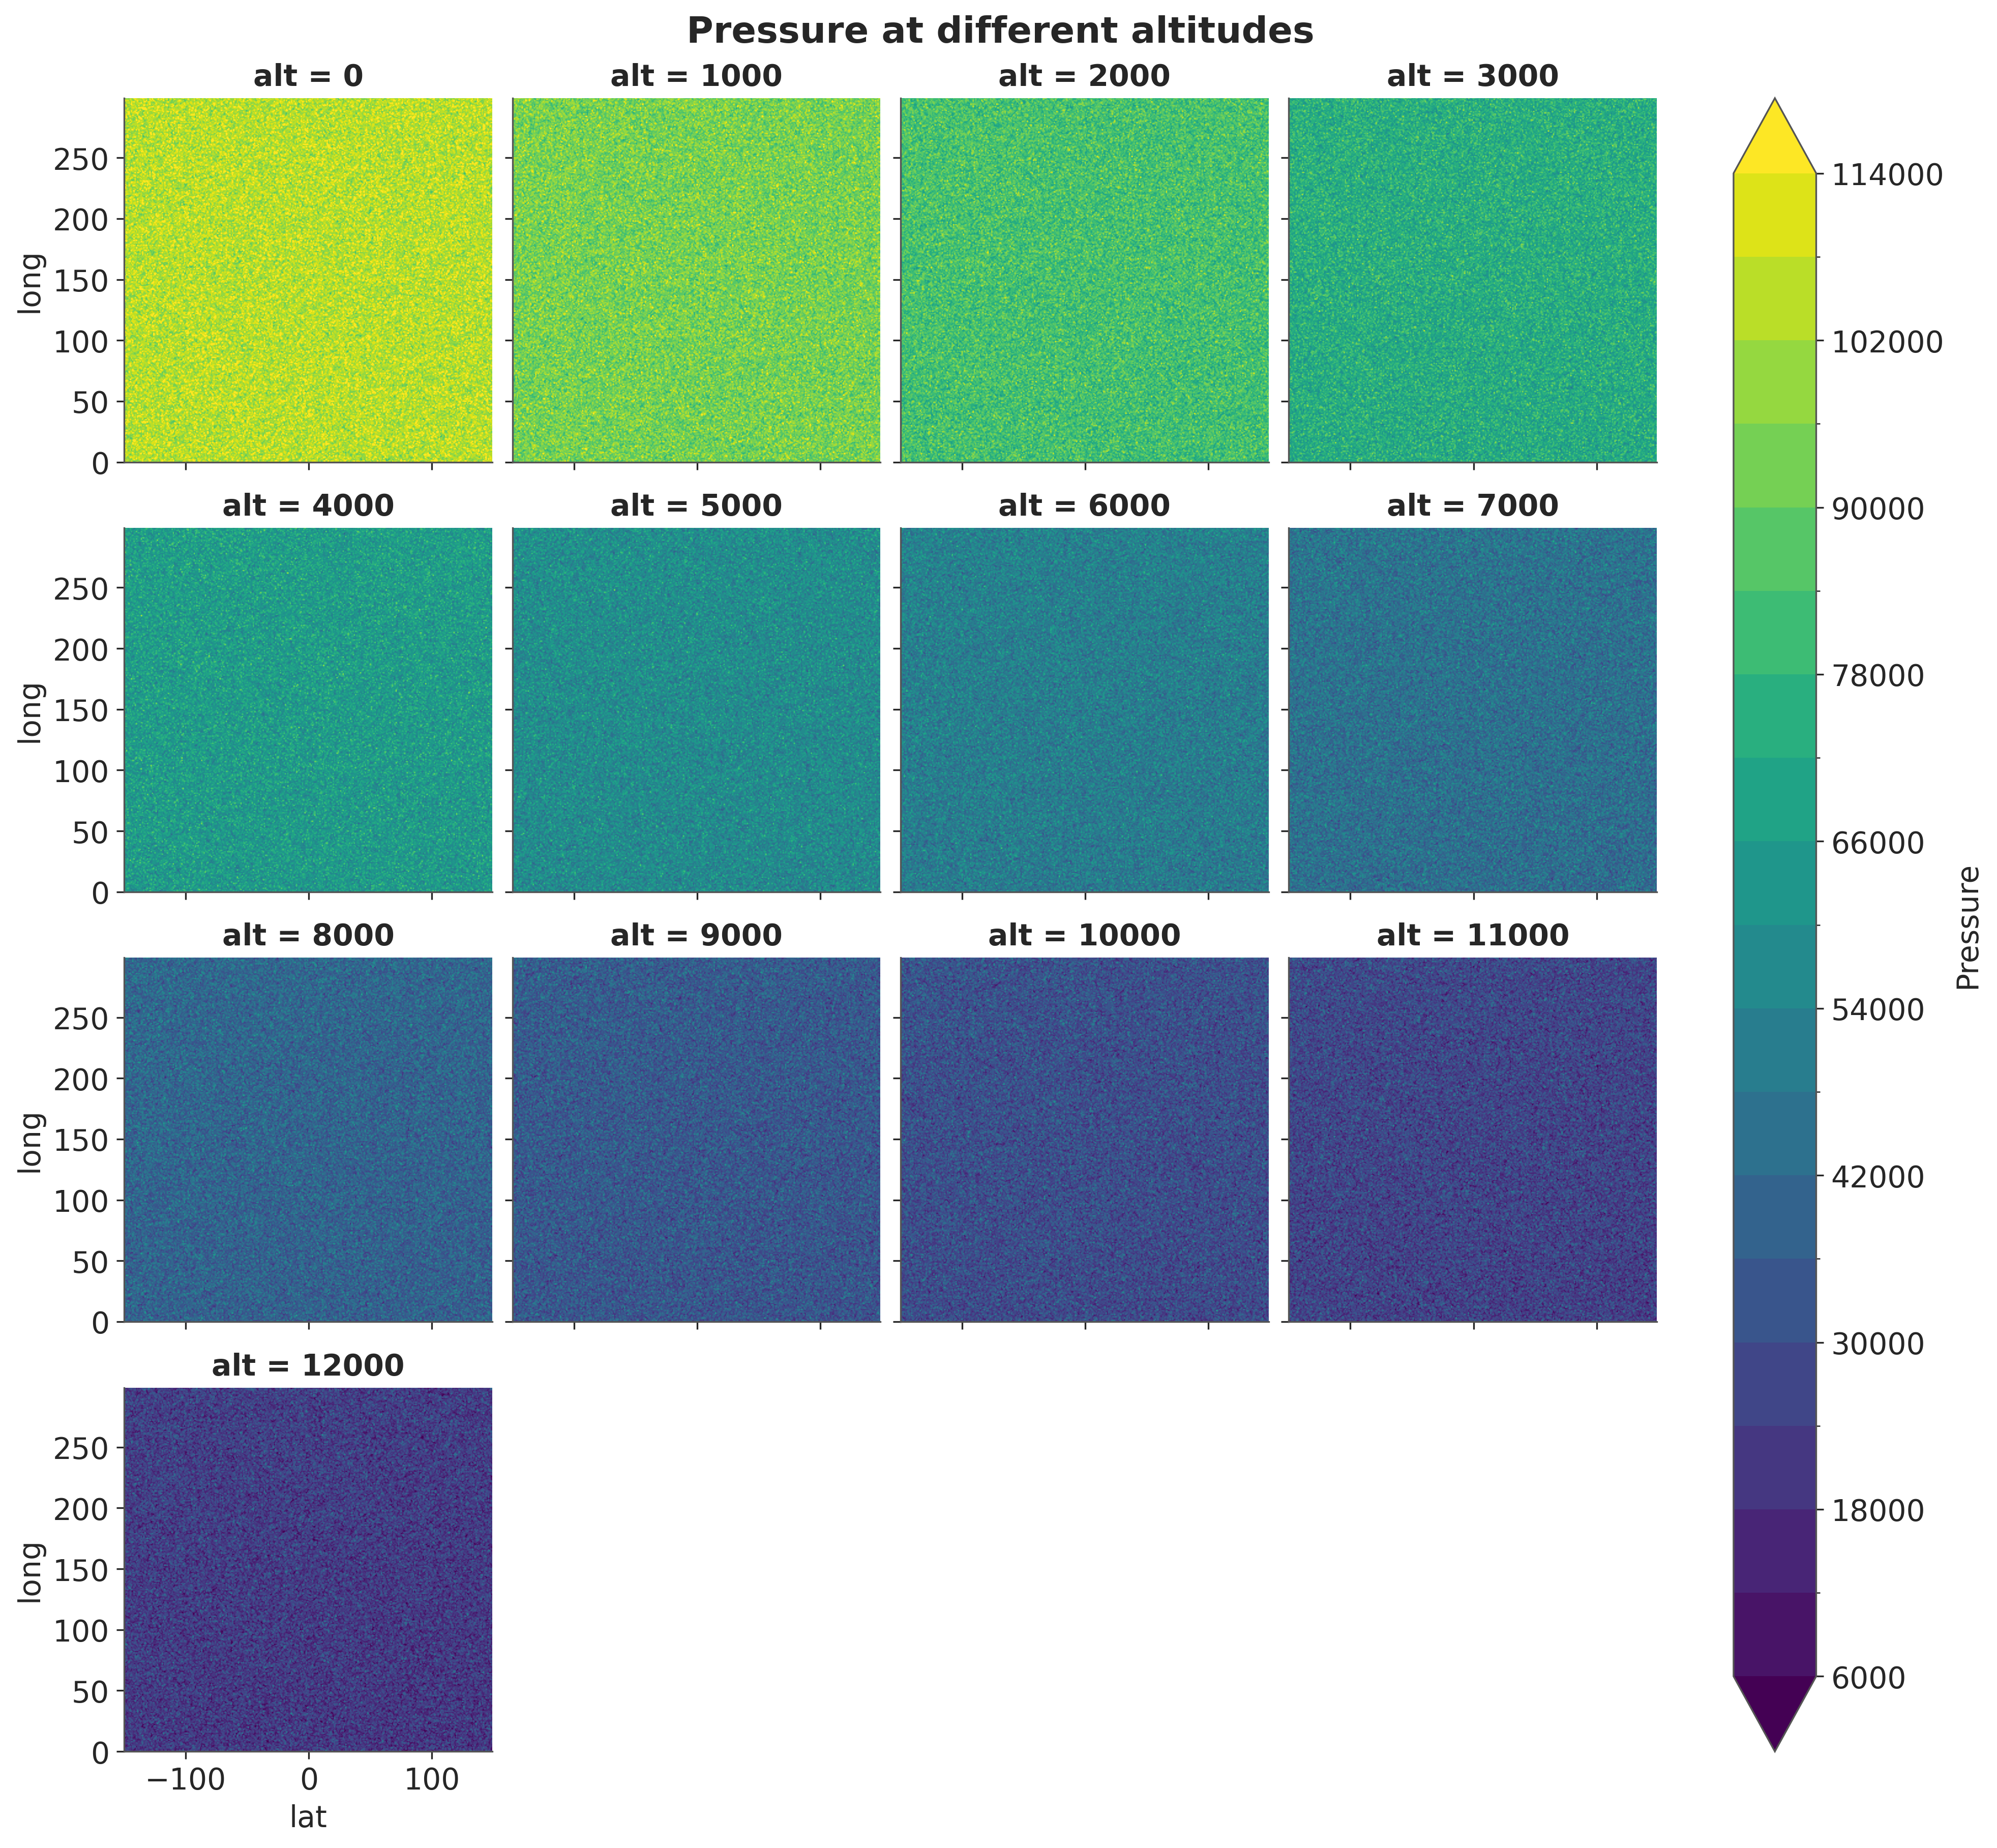

In [51]:

xr_temp_pres.Pressure.plot.contourf(x='lat',y='long', col='alt', col_wrap=4,
                         robust=True, levels=20)
plt.suptitle('Pressure at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)


C:\Users\willi\AppData\Local\Temp\ipykernel_30644\578976387.py:12: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)


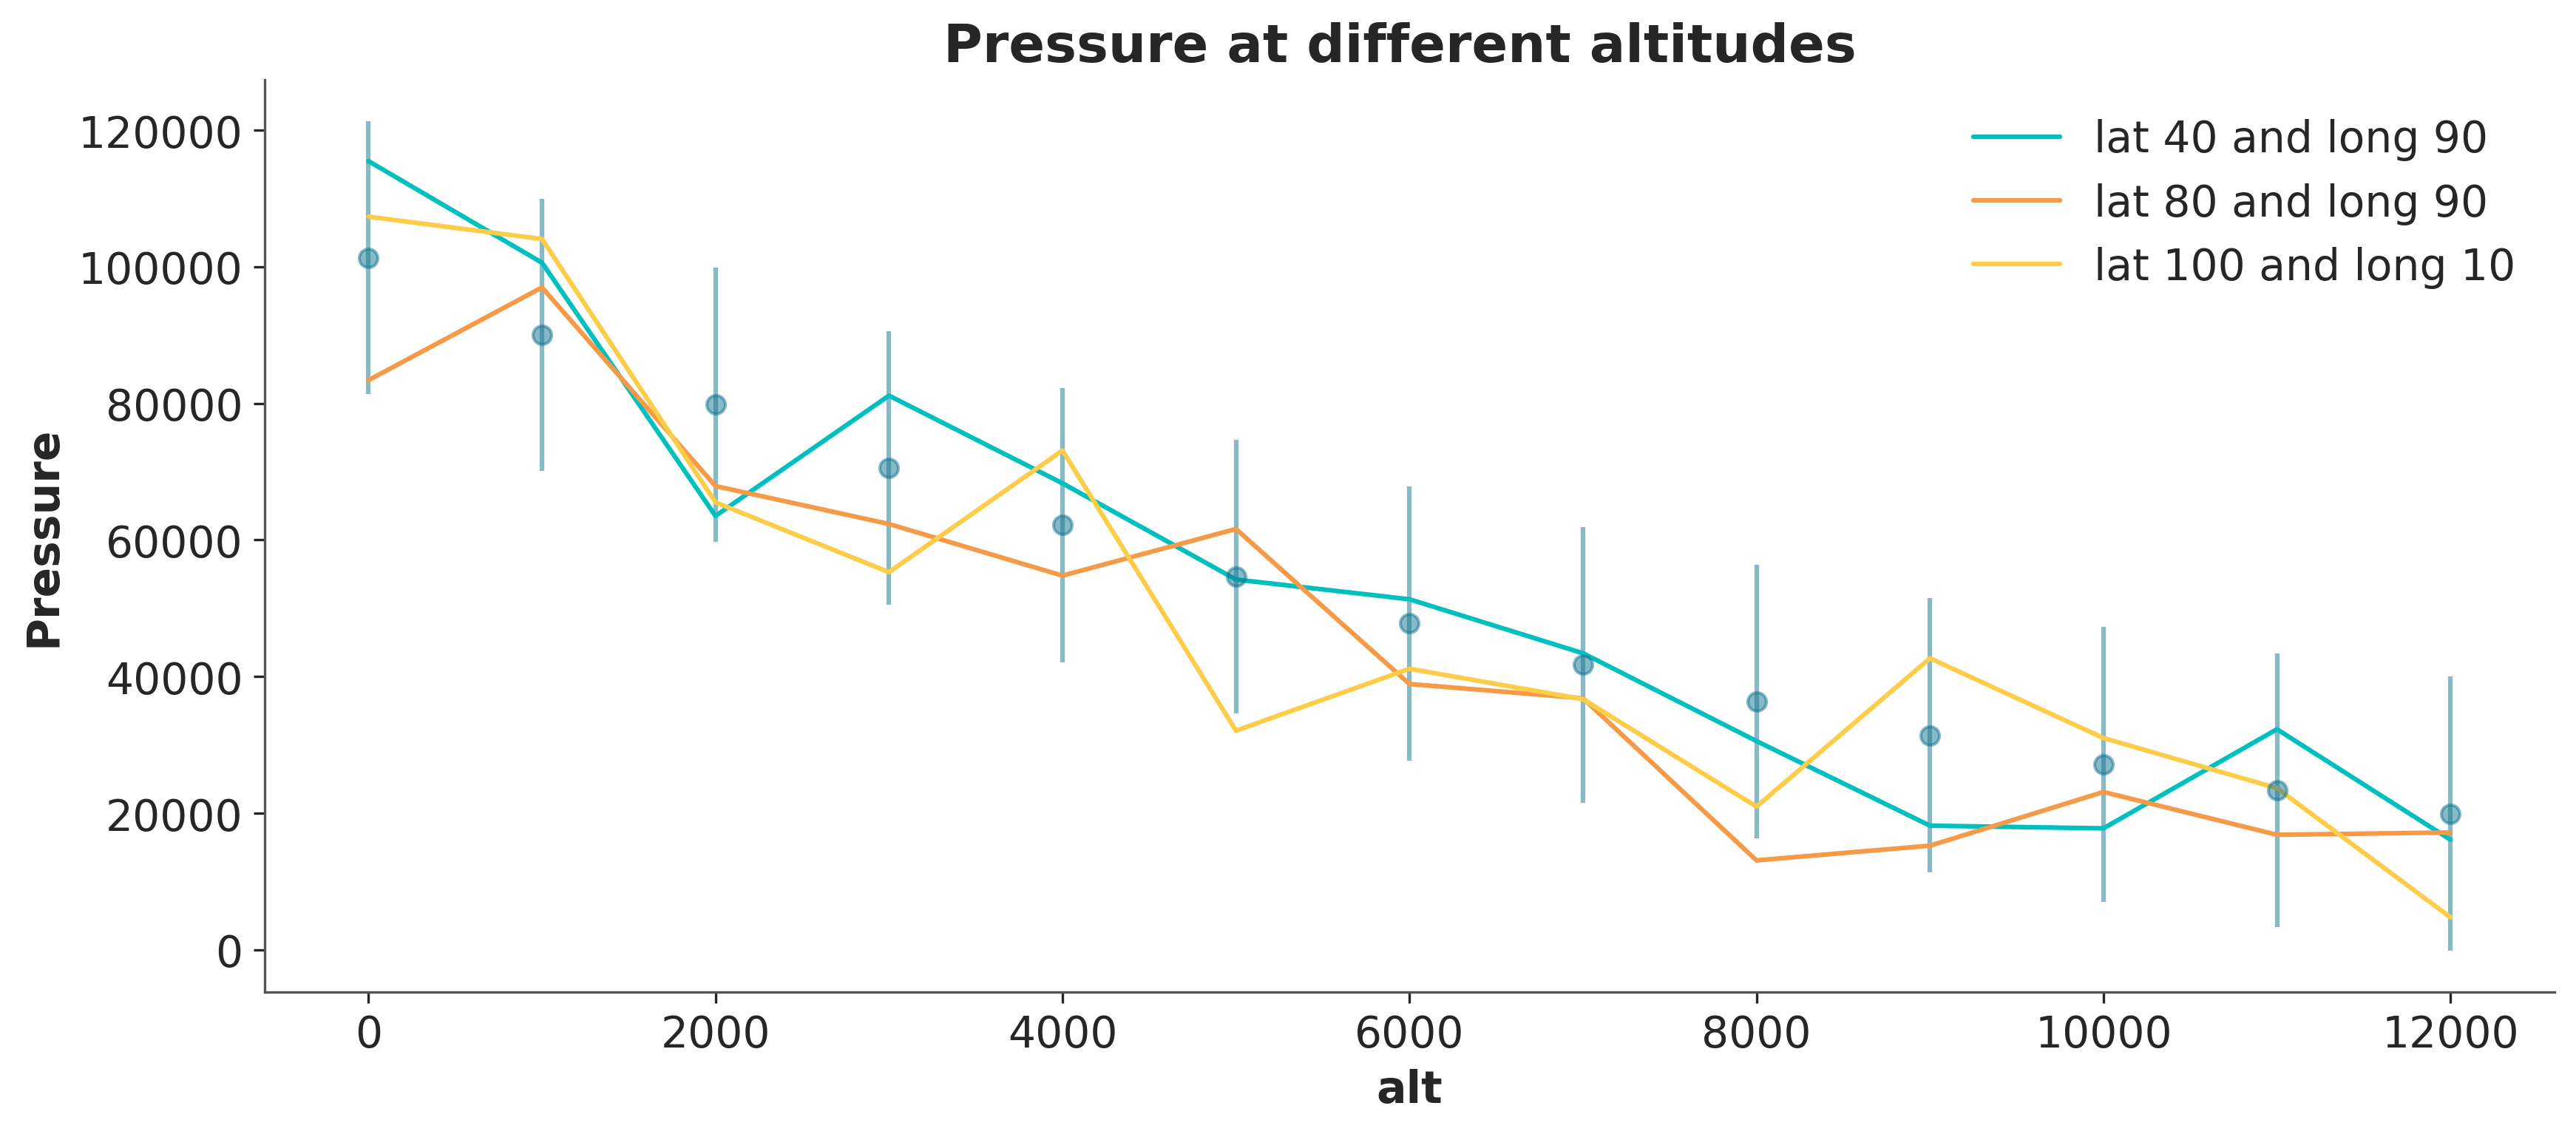

In [52]:

#xr_temp_pres.mean(['lat', 'long']).plot.scatter(x='alt', y='Pressure' )
# add error bars to scatter plot
plt.errorbar(x=xr_temp_pres.mean(['lat', 'long']).alt, y=xr_temp_pres.mean(['lat', 'long']).Pressure,
                yerr=2*xr_temp_pres.std(['lat', 'long']).Pressure, fmt='o', alpha=0.5)

plt.title('Pressure at different altitudes', fontsize = 'xx-large',
                weight = 'extra bold')
plt.xlabel('Altitude (m)', fontsize = 'x-large',
                weight = 'extra bold')
plt.ylabel('Pressure (Pa)', fontsize = 'x-large',
                weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)
#plt.show()

# plot pressure at different altitudes for lat 55 and long 90 and lat 80 and long 90
xr_temp_pres.sel(lat=55, long=90).Pressure.plot.line(x='alt')
xr_temp_pres.sel(lat=80, long=90).Pressure.plot.line(x='alt')
xr_temp_pres.sel(lat=100, long=10).Pressure.plot.line(x='alt')
title = 'Pressure at different altitudes '
plt.title(title, fontsize = 'xx-large', weight = 'extra bold')
plt.legend(['lat 40 and long 90', 'lat 80 and long 90', 'lat 100 and long 10'])


# Make trajectory and get corresponding temp and pres


In [ ]:
# make Z = a function of time and  X = sin of time and y = cos of time
recording_time_hr = 5
time = pd.to_datetime( np.arange(0, recording_time_hr*60*60, 1), unit='s')
print(time)


In [ ]:

release_alt = 12_000 #Troposphere goes to about 12Km, thermal is about linear there
step_alt = 1
turn_rate = 1.14 #turns per hour
x = (np.sin((time.hour+time.minute/60 +time.second/3600)*(2*np.pi)*turn_rate) +1) * (size-horz_offest )/2.50 + horz_offest +5
y = (np.cos((time.hour+time.minute/60 +time.second/3600)*(2*np.pi)*turn_rate) +1 ) * (size-horz_offest )/3  +5
#create samples from normal distribution and sort them
samples = stats.weibull_max.rvs(2.9, loc=0, scale=1, size=len(time), random_state=None)
samples.sort()
steps = samples/(samples.max()-samples.min()) /1.3  #normalize and shrink
steps = steps - steps.min() #shift to 0
 #smaller step per time
z = release_alt * (1- steps)

plt.plot(time, z)
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude vs Time')
ax = plt.gca()
ax.set_ylim(0, 12000)
plt.show()
#plot 3d trajectory of z by x and y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_zlim(0, 12000)
plt.title('3D Trajectory')
plt.show()


In [ ]:

#select from xarray the temperature at the pressure of the trajectory
xr_traj_env = xr.DataArray()

xr_x = xr.DataArray(x, dims=['time'], coords={'time': time})
xr_y = xr.DataArray(y, dims=['time'], coords={'time': time})
xr_z = xr.DataArray(z, dims=['time'], coords={'time': time})

xr_traj_env = xr_temp_pres.interp(lat=xr_x,long=xr_y,alt=xr_z)#, method='nearest')
xr_traj_env = xr_traj_env.interpolate_na(dim='time', method='linear', fill_value="extrapolate")
xr_traj_env.attrs =dict(units='seconds since 1970-01-01 00:00:00')
 # delay start of trajectory
xr_traj_env['time'] = xr_traj_env.time +pd.Timedelta(hours=.75)

xr_traj_env



# Put in Ballon data


In [ ]:

ballon_alt_samples = np.arange(start=0,stop=max_alt_Km*1000+1,step=500)
ballon_time = ballon_alt_samples/5
ballon_time = pd.to_datetime(  ballon_time, unit='s')
ballon_lat = [50, 100]
ballon_long = [90, 40]
'''ballon_lat = [55, 120, 50, 139, 90]
ballon_long = [15, 10, 90, 95, 25]'''
launch_count = len(ballon_lat)
ballon_delay = [pd.Timedelta(hours=i)
                for i in [0,9]#[0,5,6.5,8,9]
                ]# 7*60*60 # 7 hrs later in seconds
launch_idx = np.arange(0,launch_count)
def ballon_release(xr_temp_pres, ballon_alt_samples, ballon_time, ballon_lat, ballon_long, ballon_delay, launch_idx):
    #ballon launch delay is in hours, will convert number to pd.Timedelta
    #ballon_delay = pd.Timedelta(hours=ballon_delay)
    coords={'launch':[launch_idx],'time':(('time'),ballon_time+ballon_delay)}
    xr_ballon_env = xr_temp_pres.interp(lat=
                                    xr.DataArray([[ballon_lat[launch_idx]]]*len(ballon_time), 
                                                 dims=['time','launch'],
                                                 coords=coords),
                                    long=
                                    xr.DataArray([[ballon_long[launch_idx]]]*len(ballon_time)
                                    ,
                                                 dims=['time','launch'],
                                                 coords=coords),
                                    alt=
                                    xr.DataArray([ballon_alt_samples],
                                                 dims=['launch','time'],
                                                 coords=coords),
                                    )
    xr_ballon_env= xr_ballon_env.interpolate_na(dim='time',method='linear', fill_value = 'extrapolate')
    xr_ballon_env.attrs =dict(units='seconds since 1970-01-01 00:00:00')
    return xr_ballon_env

#TODO: remove the 'launch' dimension from the ballon_release function, then do not squeeze it out
xr_ballon_env_lst = [ballon_release(xr_temp_pres, ballon_alt_samples, ballon_time,

                                 ballon_lat, ballon_long, ballon_delay[i], launch_idx=i).squeeze()
                                   for i in np.arange(launch_count)

                    ]
xr_ballon_env = xr.concat(xr_ballon_env_lst, dim='time')



xr_ballon_env


In [ ]:

xr_traj_env = xr.concat([xr_traj_env, 
                         xr_ballon_env.drop('launch')],
                           dim='time').sortby('time')
#plot 3d trajectory of z by x and y

def plot_traj_3d(xarray=None, elev = 90, azim = -90, roll = 0, **kwargs):
    title_str = '3D Trajectory'
    # get values from kwargs
    if kwargs:
        for key, value in kwargs['kwargs'].items():
            if key == 'elev':
                elev = value
            elif key == 'azim':
                azim = value
            elif key == 'roll':
                roll = value
            elif key == 'title':
                title_str = value
            else:
                print(f'Unknown keyword argument {kwargs}')

    print(elev, azim, roll, title_str)
    xr_x= xarray
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xr_x.lat,
            xr_x.long,
            xr_x.alt)
    ax.set_xlabel('Lat')
    ax.set_ylabel('Long')
    ax.set_zlabel('Alt')
    ax.set_zlim(0, xr_x.alt.max())
    #change the view angle
    ax.view_init(elev, azim, roll)
    plt.title(title_str)
    plt.show()

view_perspectives ={'top': dict(elev=90, azim=-90, roll=0, title='Top View'), 
                    'ortho': dict(elev=30, azim=-40, roll=0, title='Orthographic View'), 
                    'side': dict(elev=0, azim=90, roll=0, title='Side View'), 
                    'front': dict(elev=0, azim=0, roll=0, title='Front View')}
print(view_perspectives['front'])

'''fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')
#plot each view'''
ax1 = plot_traj_3d(xr_traj_env, kwargs=view_perspectives['top'])
# set subplot axes title


ax2 = plot_traj_3d(xr_traj_env, kwargs=view_perspectives['ortho'])
#ax2.set_title('Orthographic View')
ax3 = plot_traj_3d(xr_traj_env, kwargs=view_perspectives['side'])
#ax3.set_title('Side View')
ax4 = plot_traj_3d(xr_traj_env, kwargs=view_perspectives['front'])
#ax4.set_title('Front View')
plt.show()


In [ ]:

xr_traj_env.Temperature.plot.scatter(x='time',color='black')
plt.suptitle('Temperature over time', fontsize = 'xx-large')
plt.show()
#make each dot black
xr_traj_env.Pressure.plot.scatter(x='time', y='Pressure', color='black')
plt.suptitle('pressure over time', fontsize = 'xx-large')
plt.show()



# downsample from xarray


In [ ]:

#must be a datetime index in xarray
# move xarray coordinate to variable

'''xr_traj_env_time = xr_traj_env.reset_coords(['lat','long','alt'], drop=False)
resample_period = '10min'
xr_traj_env_time = xr_traj_env_time.resample(time=resample_period, restore_coord_dims=True).mean().dropna(dim='time')
xr_traj_env_time_coords = xr_traj_env_time.copy(deep=True)
#Move variable to xarray coordinate multiindex
xr_traj_env_time= xr_traj_env.reset_coords(['lat','long','alt'], drop=False
                                           ).resample(time=resample_period, restore_coord_dims=True
                                                      ).mean().dropna(dim='time'
                                                                      ).set_coords(['lat','long','alt']
                                                                                   ).set_xindex(['alt','lat','long'])
xr_traj_env_time'''

In [ ]:
xr_traj_env_time = xr_traj_env.reset_coords(['lat','long','alt'], drop=False)
resample_period = '10min'
xr_traj_env_time = xr_traj_env_time.resample(time=resample_period, restore_coord_dims=True).mean().dropna(dim='time')
# get back all the ballon data - undo downsample
xr_traj_env_time_coords =  xr.combine_nested([xr_traj_env_time.set_coords(['lat','long','alt']), 
                   xr_ballon_env.drop('launch')], 
                   join='outer',
                   concat_dim='time'
                   ).sortby('time'
                            )
xr_traj_env_time = xr_traj_env_time_coords.set_coords(['lat','long','alt']
                                         ).set_xindex(['alt','lat','long'])
xr_traj_env_time

In [ ]:


plot_traj_3d(xr_traj_env_time, kwargs=view_perspectives['ortho'])
plt.show()

xr_traj_env_time_coords.Temperature.plot.scatter(x='time',color='black')
plt.suptitle('Temperature over time', fontsize = 'xx-large')
plt.show()
#make each dot black
xr_traj_env_time_coords.Pressure.plot.scatter(x='time', y='Pressure', color='black')
plt.suptitle('pressure over time', fontsize = 'xx-large')
plt.show()
# toDO CHANGE THIS VARIABLE BELOW HERE
#xarray make a multiindex of lat long alt and time

#grp_traj_env = 
# may be useful : xr_traj_env_time.stack(alt_lat_long_time=['alt','lat','long','time'],create_index=True)



# Model temp and pressure varying by altitude, lat, & long


In [ ]:
#standardize the data

def normalization(xarray=None):
    xr_x = xarray
    revert_min, revert_spread = xr_x.min(), xr_x.max()-xr_x.min()
    xr_x = (xr_x - revert_min) / revert_spread
    return xr_x, revert_min, revert_spread
def revert_normalization(xarray=None, revert_min=None, revert_spread=None):
    xr_x = xarray
    xr_x = xr_x * revert_spread + revert_min
    return xr_x
def convert_normalization(xr_old=None, xr_new=None):
    if xr_new.lat.values.size > 0:
        xr_new['lat_norm'] = (xr_new.lat - xr_old.attrs['sdz_lat_min']) / xr_old.attrs['sdz_lat_spread'] 
    if xr_new.long.values.size > 0:
        xr_new['long_norm'] = (xr_new.long - xr_old.attrs['sdz_long_min']) / xr_old.attrs['sdz_long_spread']

xr_traj_env_time['stz_lat'], sdz_min, stz_spread = normalization(xr_traj_env_time.lat)
xr_traj_env_time.attrs['sdz_lat_min'] =sdz_min.values
xr_traj_env_time.attrs['sdz_lat_spread']  =stz_spread.values
xr_traj_env_time['stz_long'], sdz_min, stz_spread = normalization(xr_traj_env_time.long)
xr_traj_env_time.attrs['sdz_long_min'] =sdz_min.values
xr_traj_env_time.attrs['sdz_long_spread']  =stz_spread.values
xr_traj_env_time['stz_alt'], sdz_min, stz_spread = normalization(xr_traj_env_time.alt)
xr_traj_env_time.attrs['sdz_alt_min'] =sdz_min.values
xr_traj_env_time.attrs['sdz_alt_spread']  =stz_spread.values

xr_traj_env_time

In [ ]:

'''coords={'alt_lat_long_time':
                      np.arange(xr_traj_env_time.sizes['time'], dtype=int)
                      }'''
with pm.Model() as thermal_pres:
    #set coords in here to be mutable
    thermal_pres.add_coord('alt_lat_long_time', np.arange(xr_traj_env_time.sizes['time'], dtype=int), mutable=True)
    #Temp is in celcius
    
    Alt_ = pm.MutableData('Altitude_m', xr_traj_env_time.alt.values,# use normal un-normalized data
                                          dims='alt_lat_long_time' )
    Lat_ = pm.MutableData('Latitude', xr_traj_env_time.stz_lat.values,
                                        dims='alt_lat_long_time' )
    Long_ = pm.MutableData('Longitude', xr_traj_env_time.stz_long.values,
                                          dims='alt_lat_long_time' )
    Temp_ = pm.MutableData('Temperature_Samples', xr_traj_env_time.Temperature.values, dims='alt_lat_long_time' )
    Pres_ = pm.MutableData('Pressure_Samples', xr_traj_env_time.Pressure.values, dims='alt_lat_long_time' )
    #prior on effect on temp (degC) of altitude and lat, long
    baseline_temp = pm.Normal('baseline_temp', mu=17, sigma=5)
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=-6, sigma=0.5)
    Lat_effect_temp = pm.Normal('Lat_effect_temp', mu=0, sigma=10/4)
    Long_effect_temp = pm.Normal('Long_effect_temp', mu=0, sigma=25/4)
    Lat_Long_effect_temp = 0  #pm.Normal('Lat_Long_effect_temp', mu=0, sigma=1)
    #prior on temp and pressure
    #TODO: PULL FROM DATABASE into a pm.Interpolated...maybe not: need relationship between data spreads?
    mu_t = pm.Deterministic('mu_t',
                               baseline_temp + 
                               Alt_effect_temp/1000 * Alt_ + 
                               Lat_effect_temp * Lat_ + 
                               Long_effect_temp * Long_ + 
                               Lat_Long_effect_temp * Lat_ * Long_, 
                               dims='alt_lat_long_time')

    P0 = pm.Normal('P0', mu=1, sigma=.01)*101_325.00 # lat/long influence on ground level temp captured in Temp_0
    g0 = 9.80665
    M = 0.0289644
    R = 8.3144598
    # NOTE: Temp_[0] is not the lowest altitude temperature, but the first temperature in the array
    Temp_0 = baseline_temp+ Lat_effect_temp * Lat_ + Long_effect_temp * Long_ # account for lat/long influence on ground level temp
    mu_p= pm.Deterministic('mu_p',P0 *  ((mu_t+273.15)/(Temp_0+273.15)) ** (-g0 * M / (R * (Alt_effect_temp/1000))), 
                                 dims='alt_lat_long_time')
    #add_barometric_effects = P0 * (T/T0) ** (-g0 * M / (R * L))
    #prior on error variation
    sigma_t=pm.Exponential('model_error_t', 1/5)
    sigma_p=pm.Exponential('model_error_p', 1/500)
    #adjusted temp - normal dist error term
    obs_t = pm.Normal('obs_t', mu=mu_t, sigma=sigma_t,  observed = Temp_, dims='alt_lat_long_time')
    obs_p = pm.Normal('obs_p', mu=mu_p, sigma=sigma_p, observed = Pres_, dims='alt_lat_long_time')
    
pm.model_to_graphviz(thermal_pres)
print(pm.str_for_model(thermal_pres))


## Examine the priors selected and their match to the observed

In [ ]:
with thermal_pres:
    idata = pm.sample_prior_predictive(1000)
az.plot_ppc(idata, group='prior', kind='cumulative')


## Run MCMC bayesian sampler

In [ ]:
with thermal_pres:
    idata.extend(pm.sample(1000, tune=1000, chains = 4, cores=1))
    # pymc sample posterior predictive check
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    az.plot_ppc(idata, group='posterior', kind='cumulative')

In [ ]:
#As i am going to be messing with coordinates and attributes, i am going to make a copy of the data
idata2 = idata.copy()
idata2

In [ ]:
az.rcParams["plot.backend"] = "matplotlib"


In [ ]:
correctsignsize_mean_tempC_Km= -mean_tempC_Km*1000
az.plot_trace(idata2, lines = (('Alt_effect_temp_Km', {},[correctsignsize_mean_tempC_Km]),
                              #('Lat_effect_temp',{}, lat_inc_slope  ),
                              #('Long_effect_temp',{}, long_inc_mu  ), ))
                              #('Lat_effect_temp',{}, lat_inc_slope / xr_traj_env_time_scaled.attrs['sdz_lat_spread'] ),
                              #('Long_effect_temp',{}, long_inc_mu / xr_traj_env_time_scaled.attrs['sdz_long_spread'] ), ))
                              ('Lat_effect_temp',{}, lat_inc_slope  * xr_traj_env_time.attrs['sdz_lat_spread'] ),  
                              ('Long_effect_temp',{}, long_inc_mu * xr_traj_env_time.attrs['sdz_long_spread'] ), ))

plt.subplots_adjust (hspace=0.4)#, wspace=0.4)

In [ ]:
sortby_alt = xr.DataArray(idata2.constant_data.Altitude_m.values,
                                              coords={'alt_lat_long_time':idata2.constant_data.alt_lat_long_time.values})
idata2 = idata2.map(lambda ds, **kwarg: ds.sortby(**kwarg), groups= ["~sample_stats"],variables=sortby_alt, ascending=False)
idata2 = idata2.map(lambda ds, **kwarg: ds.assign_coords(**kwarg), 
           groups=['prior_predictive', 'posterior_predictive', 'observed_data'], 
           Altitude_m=(['alt_lat_long_time'], idata2.constant_data.Altitude_m.values))

idx_sortby_alt = idata2.constant_data.alt_lat_long_time.values


In [ ]:
#xarray filter by values - used in grouping graphs
lat_min = idata2.constant_data.Latitude.min()
lat_max = idata2.constant_data.Latitude.max()
long_min = idata2.constant_data.Longitude.min()
long_max = idata2.constant_data.Longitude.max()
lat_mid = (lat_min + lat_max)/2
long_mid = (long_min + long_max)/2

idx_north = idata2.constant_data.where(idata2.constant_data.Latitude>lat_mid, drop=True).alt_lat_long_time.values
idx_south = idata2.constant_data.where(idata2.constant_data.Latitude<lat_mid, drop=True).alt_lat_long_time.values
idx_east = idata2.constant_data.where(idata2.constant_data.Longitude>long_mid, drop=True).alt_lat_long_time.values
idx_west = idata2.constant_data.where(idata2.constant_data.Longitude<long_mid, drop=True).alt_lat_long_time.values


In [ ]:
# creating class for labeling the altitude instead of variable index
class DimCoordLabeller_alt(azl.BaseLabeller):
    """WIP."""
    def __init__(self, coords):
        self.coords_ds = xr.Dataset(coords)
        display(self.coords_ds)

    def dim_coord_to_str(self, dim, coord_val, coord_idx):
        """WIP."""#format decimals in f statement
        temp =  self.coords_ds.sel(pointwise_sel=coord_val).items()
        temp = [(v.values) for _,v in temp][0]
        return f"{temp:.2f}" 
    
coords = {
    'alt_lat_long_time': xr.DataArray(
        idata2.constant_data.Altitude_m.values, 
        dims=['pointwise_sel'],coords={'pointwise_sel': idata2.constant_data.alt_lat_long_time.values}
    )
}        
labeller = DimCoordLabeller_alt(coords=coords)
display(coords)

In [ ]:
#figures with lat in coulmns and long in rows
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
for i, ((N_S_label,N_S_idx), (E_W_label,E_W_idx)) in enumerate([[i,j] 
                                  for i in [('North',idx_north),('South',idx_south)] 
                                  for j in [('West',idx_west), ('East',idx_east)]]):
    print(N_S_label,E_W_label)
    ax[i].set_title(f'Lat: {N_S_label} Long: {E_W_label}')
    idx = np.intersect1d(N_S_idx,E_W_idx)
    az.plot_forest(idata2.sel(alt_lat_long_time=[x for x in idx_sortby_alt
                                                 if np.any(np.isin(idx,x))]),
                   var_names=['mu_t'],
                   kind='ridgeplot', 
                   combined=True, ax= ax[i],
                   labeller=labeller,
                   backend='matplotlib'
                   )
    #align the y axis
    #ax[i].set_ylim(0, 10000)
    ax[i].set_xlim(-50, 30)
    ax[i].grid()


In [ ]:

az.plot_forest(idata2.sel( alt_lat_long_time=idx_sortby_alt), var_names=['mu_t'],kind='ridgeplot', combined=True,labeller=labeller, backend='matplotlib')
az.plot_forest(idata2.sel( alt_lat_long_time=idx_sortby_alt), var_names=['mu_p'],kind='ridgeplot', combined=True,labeller=labeller)


In [ ]:
idata_pred_Alt = idata2.map( lambda ds, **kwarg: 
                                   ds.swap_dims(**kwarg).drop('alt_lat_long_time'),#.drop_indexes('Altitude_m'), 
                                   groups=['observed','predictive'], filter_groups='like', 
                                   alt_lat_long_time='Altitude_m')
group_alt_by = 2000
idata_pred_Alt = idata_pred_Alt.map(lambda ds: ds.assign_coords(Altitude_grpd = ds.Altitude_m // group_alt_by *group_alt_by
                                                                ).swap_dims({'Altitude_m':'Altitude_grpd'}
                                                                            ).drop('Altitude_m'),
                                                                            groups=['observed','predictive'], 
                                                                            filter_groups='like')

#display(idata_pred_Alt)
az.plot_dist_comparison(idata_pred_Alt, 
                        kind='observed', 
                        #labeller=labeller, 
                        )
plt.show()

In [ ]:
az.plot_dist_comparison(idata_pred_Alt, 
                        kind='observed', 
                        var_names=['obs_p']
                        #labeller=labeller, 
                        )
plt.show()

# Save off model and trace

In [ ]:

# save off pymc model
def save_pymc_trace( trace=None, xr_data_source=None, filename='pymc_meodel', multi_index_to_reset =None):
    trace_copy = trace.copy()
    if xr_data_source:
        if multi_index_to_reset:
            print('adding this', xr_data_source.reset_index(multi_index_to_reset))
            trace_copy.add_groups({'data_source':xr_data_source.reset_index(multi_index_to_reset)})
        else:
            trace_copy.add_groups({'data_source':xr_data_source})

    trace_copy.to_netcdf(f'{filename}.nc')#to_zarr(filename)#
        
    #just rerun the model with no observed data
    #with open(filename, 'wb') as buff:
    #    pickle.dump({'model':model}, buff)
# open pymc model and inference object
def open_pymc_trace(filename='pymc_meodel'):
    temp_idata = az.from_netcdf(f'{filename}.nc')#az.InferenceData.from_zarr(filename)#
    
    return temp_idata  #data['model'],


In [ ]:
with thermal_pres:
    #save_pymc_trace(trace=idata2, xr_data_source =xr_traj_env_time , filename='thermal_pres', multi_index_to_reset='time')
    save_pymc_trace(trace=idata2 , filename='thermal_pres')


In [ ]:
az.rcParams["data.load"] = "eager"
idata3 = open_pymc_trace(filename='thermal_pres')

In [ ]:
idata3

# Implement Counterfactual (what-if)

In [ ]:
az.rcParams["plot.backend"] = "bokeh"

In [ ]:
# convert lat and long to the normalized transform (does it inplace in the new dataset)
def investigate_dic(lat = [100, 100, 100, 100], long = [250, 100, 250, 100], alt = [5, 5, 20000, 20000]):
    investigate_lat_long = xr.Dataset(data_vars={
    'lat': lat,
    'long': long,
    'Altitude_m': alt,
    'Temperature_Samples': [0, 0, 0,0],
    'Pressure_Samples' :[0,0,0,0],
    })
        
    return investigate_lat_long

investigate_lat_long = investigate_dic()

def make_temp_prediction(investigate_lat_long, trace=idata2):
    convert_normalization(xr_old= xr_traj_env_time,xr_new = investigate_lat_long)
    new_length = len(investigate_lat_long.Temperature_Samples.values)
    new_coord_values = (trace.constant_data.alt_lat_long_time.values.max() +1) + np.arange(new_length)

    with thermal_pres:
        thermal_pres.set_dim(name='alt_lat_long_time', 
                         new_length=new_length,
                         coord_values=new_coord_values)
    
    with thermal_pres:
    # do-operator
        pm.set_data({'Altitude_m': investigate_lat_long.Altitude_m.values,
                 'Latitude': investigate_lat_long.lat_norm.values,
                 'Longitude': investigate_lat_long.long_norm.values,
                 'Temperature_Samples': investigate_lat_long.Temperature_Samples.values,
                 'Pressure_Samples' : investigate_lat_long.Pressure_Samples.values,
                 })
    
    # sample from this out of sample posterior predictive distribution
        counterfactual = pm.sample_posterior_predictive(trace, var_names=["obs_t"], predictions=True, progressbar=False)
    counterfactual.predictions
# make seaborn violin plots along alt_lat_long_time dimension from counterfactual xarray dataset


    counterfactual.predictions_constant_data['Longitude'] = revert_normalization( counterfactual.predictions_constant_data.Longitude, 
                     revert_min=xr_traj_env_time.attrs['sdz_long_min'], 
                     revert_spread=xr_traj_env_time.attrs['sdz_long_spread'])
    counterfactual.predictions_constant_data['Latitude'] = revert_normalization( counterfactual.predictions_constant_data.Latitude,
                        revert_min=xr_traj_env_time.attrs['sdz_lat_min'],
                        revert_spread=xr_traj_env_time.attrs['sdz_lat_spread'])
    counterfactual.predictions=counterfactual.predictions.assign_coords(counterfactual.predictions_constant_data[['Latitude', 'Longitude', 'Altitude_m']])
                            
    return counterfactual

counterfactual = make_temp_prediction(investigate_lat_long)

sns.violinplot(data=counterfactual.predictions.assign_coords(
    counterfactual.predictions_constant_data[['Latitude', 'Longitude', 'Altitude_m']]).
    to_dataframe().
    reset_index(),
                x='Altitude_m', y='obs_t', hue='Longitude')
fig = plt.gcf()
fig.set_size_inches(8,10)
plt.show()


In [ ]:

counterfactual

In [ ]:

# This code creates a panel that users can interact with to compare the temperature distributions at two sets of lat, long, and altitude values.  The code uses the hvplot.violin method to create the distributions.
pn.extension(sizing_mode = 'stretch_width', template='fast')

slider_lat = pn.widgets.IntSlider(name='lat', start=0, end=200, step=1, value=50) # lat slider
slider_long = pn.widgets.IntSlider(name='long', start=0, end=200, step=1, value=50) # long slider
slider_alt = pn.widgets.IntSlider(name='alt', start=0, end=20_000, step=500, value=500) # alt slider

# second set for comparison
slider_lat2 = pn.widgets.IntSlider(name='lat', start=0, end=200, step=1, value=50) # lat slider
slider_long2 = pn.widgets.IntSlider(name='long', start=0, end=200, step=1, value=50) # long slider
slider_alt2 = pn.widgets.IntSlider(name='alt', start=0, end=20_000, step=500, value=500) # alt slider

no_slider = [0]

#plot_prediction takes in the coordinates of a point, and the number of samples to take from the distribution. It then plots the distribution of temperature at that point.
#az.plot_violin
def plot_prediction(slider_lat=50, slider_long=50, slider_alt=500, no_slider=[0], var_names="obs_t"):
    
    return make_temp_prediction(xr.Dataset(data_vars={
    'lat': [slider_lat],
    'long': [slider_long],
    'Altitude_m': [slider_alt],
    'Temperature_Samples': no_slider,
    'Pressure_Samples' :no_slider,
    })
    ).predictions.swap_dims({'alt_lat_long_time':'Altitude_m'}).hvplot.violin(y='obs_t',ylabel='Temperature (degC)',
                 legend=False, title=f'Temperature Distribution at {slider_lat} lat, {slider_long} long, {slider_alt} alt',
                 width=500, height=500, padding=0.4, shared_axes=True)

def plot_prediction2(slider_lat=50, slider_long=50, slider_alt=500,
                     slider_lat2 = slider_lat2, slider_long2= slider_long2, slider_alt2=slider_alt2,
                       no_slider=[0], var_names="obs_t"):
    both = plot_prediction(slider_lat=slider_lat, 
                           slider_long=slider_long, 
                           slider_alt=slider_alt) + plot_prediction(slider_lat=slider_lat2,
                                                                    slider_long=slider_long2, 
                                                                    slider_alt=slider_alt2)
    return both
     
    
    

pre_plot = plot_prediction()

display_pn = pn.bind(plot_prediction2,
                     slider_lat=slider_lat, 
                     slider_long=slider_long, 
                     slider_alt=slider_alt,
                     slider_lat2=slider_lat2, 
                     slider_long2=slider_long2, 
                     slider_alt2=slider_alt2)
#display_pn2 = pn.bind(plot_prediction,slider_lat=slider_lat2, slider_long=slider_long2, slider_alt=slider_alt2)

really_display_pn = pn.Column(pn.Row('##Interactive Temperature Comparison'),
                              pn.Row(pn.Column(slider_lat, slider_long, slider_alt),pn.Column(slider_lat2, slider_long2, slider_alt2)),
                              pn.Row(display_pn))
#sync the y axis of both graphs
#really_display_pn[2][0][0].link(really_display_pn[2][1][0], bidirectional=True, links={'ylim':'ylim'}) 
really_display_pn
